In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import torch.nn as nn

from utils import *

## Get lattice with Cheetah

In [2]:
import sys
sys.path.insert(0, '/sdf/data/ad/ard/u/zihanzhu/code_dev/cheetah/')

In [3]:
import cheetah

In [4]:
cheetah?

Type:        module
String form: <module 'cheetah' from '/sdf/data/ad/ard/u/zihanzhu/code_dev/cheetah/cheetah/__init__.py'>
File:        /sdf/data/ad/ard/u/zihanzhu/code_dev/cheetah/cheetah/__init__.py
Docstring:   <no docstring>

#### Load lattice from bmad

In [5]:
# cu_hxr_file_path = (
#     Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
# )
BEAMPATH = "cu_hxr/cu_hxr.lat.bmad"
cu_hxr_file_path = f'$LCLS_LATTICE/bmad/models/{BEAMPATH}'
lcls_lattice_dir = os.environ["LCLS_LATTICE"]
lcls_cu_segment = (
    cheetah.Segment.from_bmad(
    str(cu_hxr_file_path),
    environment_variables={"LCLS_LATTICE": lcls_lattice_dir},
    dtype=torch.float64,
))

#### Load lattice from Elegant (doesn't work well)

In [9]:
BEAMPATH = "LCLS2cu/LCLS2cuH.lte"
cu_hxr_file_path = f'/sdf/group/ad/beamphysics/zihanzhu/lcls-lattice/elegant/models/{BEAMPATH}'
lcls_lattice_dir = os.environ["LCLS_LATTICE"]
lcls_cu_segment = (
    cheetah.Segment.from_elegant(
        elegant_lattice_file_path=cu_hxr_file_path, 
        name='myline',dtype=torch.float64
))

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [6]:
lcls_cu_segment = lcls_cu_segment.flattened()
len(lcls_cu_segment.elements)

2263

## Bmad

In [7]:
from pytao import Tao
import pandas as pd
from util_bmad import tc, get_output, print_twiss

In [8]:
def tc(cmd, verbose: bool = False):
    result = tao.cmd(cmd)
    if verbose:
        for l in result:
            print(l)

In [9]:
track_start_element_name = 'begl3'#'otr3'#'endl1'#'beginning'#'begltuh' #'begbsyh_1' #'begl3'
track_end_element_name = 'endltuh'#'endltuh' #'endltuh'#'end' #'endclth_0'

In [10]:
#CU_HXR model
BEAMPATH = 'cu_hxr'
OPTIONS = f'-slice {track_start_element_name}:{track_end_element_name} -noplot '
# OPTIONS = f'-slice {track_start_element_name}: -noplot '
INIT = f'-init $LCLS_LATTICE/bmad/models/{BEAMPATH}/tao.init {OPTIONS}'
tao = Tao(INIT)
#tc('set ele  *::BEGUNDH:ENDUNDH  field_master=True') #QHXHs
# tc('set ele BEGINNING:END field_master=True')

# small error is expected if using default setting for num_steps
# tao.cmd('set ele lcavity::*[num_steps]=10')



In [11]:
tao.cmd('show ele Quadrupole::*')

['      1377  Q25201                                         436.052',
 '        13  Q25201#1                                       435.999',
 '        15  Q25201#2                                       436.052',
 '      1378  Q25301                                         448.396',
 '        30  Q25301#1                                       448.343',
 '        32  Q25301#2                                       448.396',
 '      1379  Q25401                                         460.741',
 '        49  Q25401#1                                       460.687',
 '        51  Q25401#2                                       460.741',
 '      1380  Q25501                                         473.085',
 '        62  Q25501#1                                       473.032',
 '        64  Q25501#2                                       473.085',
 '      1381  Q25601                                         485.430',
 '        75  Q25601#1                                       485.376',
 '    

In [45]:
tao.cmd('set ele QEM1 K1 = -1')

[]

In [46]:
bmad_output = get_output(tao)

In [9]:
tao.cmd('show ele Q25201')

NameError: name 'tao' is not defined

In [31]:
tao.cmd('show lat -s 1520:1600')

['# Values shown are for the Downstream End of each Element:',
 '# Index  name      key                       s       l    beta   phi_a    eta   orbit    beta   phi_b    eta   orbit  Track',
 '#                                                            a   [2pi]      x  x [mm]       b   [2pi]      y  y [mm]  State',
 '   1280  DU1M80CMB Drift              1520.452   4.385 1.320E6   5.773  -0.00   0.000 1.088E6   4.792   0.00   0.000  Alive',
 '   1281  DCX37     Drift              1520.532   0.080 1.323E6   5.773  -0.00   0.000 1.080E6   4.792   0.00   0.000  Alive',
 '   1282  D32CMC    Drift              1520.833   0.300 1.335E6   5.773  -0.00   0.000 1.047E6   4.792   0.00   0.000  Alive',
 '   1283  XCUM1     HKicker            1520.833   0.000 1.335E6   5.773  -0.00   0.000 1.047E6   4.792   0.00   0.000  Alive',
 '   1284  DUM1A     Drift              1521.323   0.490 1.354E6   5.773  -0.00   0.000  995962   4.792   0.00   0.000  Alive',
 '   1285  QUM1#1    Quadrupole         1

In [32]:
floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)

In [33]:
e_collimators_eles = floorplan[floorplan['ElementType']=='ECollimator']['ElementName'].tolist()
print(e_collimators_eles)
r_collimators_eles = floorplan[floorplan['ElementType']=='RCollimator']['ElementName'].tolist()
print(r_collimators_eles)
sbend_collimators_eles = floorplan[floorplan['ElementType']=='SBend']['ElementName'].tolist()
print(sbend_collimators_eles)

['PCAPM1', 'PCAPM2', 'PCAPM3', 'PCAPM4', 'PC90', 'PC119', 'PCTDKIK1', 'PCTDKIK2', 'PCTDKIK3', 'PCTDKIK4', 'PCMUON']
['C29096', 'C29146', 'C29446', 'C29546', 'C29956', 'C30146', 'C30446', 'C30546', 'CXQ6', 'CEDL1', 'CYBX32', 'CXQT22', 'CEDL3', 'CYBX36']
['BY1', 'BY2', 'BX31', 'BX32', 'BCX321', 'BCX322', 'BCX323', 'BCX324', 'BYKIK1', 'BYKIK2', 'BCX351', 'BCX352', 'BCX353', 'BCX354', 'BX35', 'BX36', 'BCX361', 'BCX362', 'BCX363', 'BCX364']


In [34]:
# Convert 'ElementName' column to a set for faster lookup
floorplan_elements = set(floorplan['ElementName'])

# Check if each element in bmad_output['ele.name'] exists in floorplan['ElementName']
for ele in bmad_output['ele.name']:
    if ele in floorplan_elements:
        pass
        # print(f"{ele} exists in floorplan.")
    else:
        print(f"{ele} does not exist in floorplan.")

BEGINNING does not exist in floorplan.
RWWAKE4H does not exist in floorplan.
ENDLTUH does not exist in floorplan.


In [18]:
tc('sho ele Q26201*',True)

      1385  Q26201                                         537.652
       132  Q26201#1                                       537.599
       134  Q26201#2                                       537.652
Number of Matches: 3


### Bmad dipole fringe_types

In [30]:
# fringe_types = ['none', 'soft_edge_only','hard_edge_only','full','linear_edge','basic_bend']
fringe_types = ['full','linear_edge','basic_bend']

In [31]:
bmad_outputs = {}

for fringe_type in fringe_types:
    tc(f'set ele BXH1 FRINGE_TYPE={fringe_type}', verbose=True)
    tc(f'set ele BXH2 FRINGE_TYPE={fringe_type}', verbose=True)
    tc(f'set ele BXH3 FRINGE_TYPE={fringe_type}', verbose=True)
    tc(f'set ele BXH4 FRINGE_TYPE={fringe_type}', verbose=True)
    bmad_output = get_output(tao)
    bmad_outputs[fringe_type] = bmad_output




## Benchmarking Cheetah 

In [47]:
def find_element_index_by_name(module_list, name):
    name_lower = name.lower()
    for idx, element in enumerate(module_list):
        if hasattr(element, 'name') and element.name.lower() == name_lower:
            print(f"Element '{element.name}' found at index: {idx}")
            return idx
    return -1  # If not found


In [48]:
cheetah_start_index = find_element_index_by_name(lcls_cu_segment.elements, track_start_element_name)
cheetah_end_index = find_element_index_by_name(lcls_cu_segment.elements, track_end_element_name)

Element 'begl3' found at index: 509
Element 'endltuh' found at index: 1497


In [49]:
name_array = np.array(bmad_output['ele.name'])

bmad_start_index = np.where(name_array == track_start_element_name.upper())[0]
# print(bmad_start_index)
bmad_end_index = np.where(name_array == track_end_element_name.upper())[0]
# print(bmad_end_index)
x_beta = bmad_output['ele.a.beta'][bmad_start_index[0]]
x_alpha = bmad_output['ele.a.alpha'][bmad_start_index[0]]
y_beta = bmad_output['ele.b.beta'][bmad_start_index[0]]
y_alpha = bmad_output['ele.b.alpha'][bmad_start_index[0]]
beam_energy = bmad_output['ele.e_tot'][bmad_start_index[0]]
print(f'Twiss parameters of the element {track_start_element_name}:')
print(f'x_beta: {x_beta}, x_alpha:{x_alpha}\ny_beta: {y_beta}, y_alpha:{y_alpha}\nE_tot:{beam_energy}')

Twiss parameters of the element begl3:
x_beta: 10.853101620922004, x_alpha:-0.9398655105006327
y_beta: 71.01202727324782, y_alpha:2.206548806306204
E_tot:5000000000.000011


### Defining beam using ParameterBeam

In [50]:
# beta_x =  5.91253676811641 # 10.853101620922  #17.2
# alpha_x = 3.5563130763366 # -0.939865510500633
emittance_x =  1e-06 #3.3523564244172698e-09

# beta_y = 5.91253676811641 #71.0120272732478 #17.2
# alpha_y =  3.5563130763366 # 2.20654881 #-4.8
emittance_y =  1e-06 #3.5209667036341894e-09
# beam_energy = 5e9


design_incoming = cheetah.ParameterBeam.from_twiss(
    beta_x=torch.tensor([x_beta]),
    alpha_x=torch.tensor([x_alpha]),
    emittance_x=torch.tensor([emittance_x]),
    beta_y=torch.tensor([y_beta]),
    alpha_y=torch.tensor([y_alpha]),
    emittance_y=torch.tensor([emittance_y]),
    energy=torch.tensor([beam_energy]),
    dtype=torch.float64,
)

print(design_incoming)
print(f'x_beta: {design_incoming.beta_x}, x_alpha:{design_incoming.alpha_x}\ny_beta: {design_incoming.beta_y}, y_alpha:{design_incoming.alpha_y}')

ParameterBeam(mu_x=tensor(0., dtype=torch.float64), mu_px=tensor(0., dtype=torch.float64), mu_y=tensor(0., dtype=torch.float64), mu_py=tensor(0., dtype=torch.float64), sigma_x=tensor([0.0033], dtype=torch.float64), sigma_px=tensor([0.0004], dtype=torch.float64), sigma_y=tensor([0.0084], dtype=torch.float64), sigma_py=tensor([0.0003], dtype=torch.float64), sigma_tau=tensor([1.0000e-06], dtype=torch.float64), sigma_p=tensor([1.0000e-06], dtype=torch.float64), energy=tensor([5.0000e+09], dtype=torch.float64)), total_charge=tensor([0.], dtype=torch.float64))
x_beta: tensor([10.8531], dtype=torch.float64), x_alpha:tensor([-0.9399], dtype=torch.float64)
y_beta: tensor([71.0120], dtype=torch.float64), y_alpha:tensor([2.2065], dtype=torch.float64)


### Defining beam using ParticleBeam

In [47]:
# x_beta =  10.853101620922004 
# x_alpha = -0.9398655105006327 
emittance_x =  1e-06 

# y_beta = 71.01202727324782 
# y_alpha =  2.206548806306204 
emittance_y =  1e-06 
# beam_energy = 5e9

num_particles = 10_000
total_charge = 250e-12

design_incoming = cheetah.ParticleBeam.from_twiss(
    num_particles=torch.tensor(num_particles),
    beta_x=torch.tensor([x_beta]),
    alpha_x=torch.tensor([x_alpha]),
    emittance_x=torch.tensor([emittance_x]),
    beta_y=torch.tensor([y_beta]),
    alpha_y=torch.tensor([y_alpha]),
    emittance_y=torch.tensor([emittance_y]),
    energy=torch.tensor([beam_energy]),
    total_charge=torch.tensor([total_charge]),
    dtype=torch.float64,
)
# design_incoming = design_incoming.double()
print(design_incoming)
print(f'x_beta: {design_incoming.beta_x}, x_alpha:{design_incoming.alpha_x}\ny_beta: {design_incoming.beta_y}, y_alpha:{design_incoming.alpha_y}')

ParticleBeam(n=10000, mu_x=tensor([-1.3786e-05], dtype=torch.float64), mu_px=tensor([-5.3383e-06], dtype=torch.float64), mu_y=tensor([-0.0002], dtype=torch.float64), mu_py=tensor([5.3286e-06], dtype=torch.float64), sigma_x=tensor([0.0033], dtype=torch.float64), sigma_px=tensor([0.0004], dtype=torch.float64), sigma_y=tensor([0.0084], dtype=torch.float64), sigma_py=tensor([0.0003], dtype=torch.float64), sigma_tau=tensor([1.0087e-06], dtype=torch.float64), sigma_p=tensor([1.0007e-06], dtype=torch.float64), energy=tensor([5.0000e+09], dtype=torch.float64)) total_charge=tensor([2.5000e-10], dtype=torch.float64))
x_beta: tensor([11.0078], dtype=torch.float64), x_alpha:tensor([-0.9655], dtype=torch.float64)
y_beta: tensor([70.5363], dtype=torch.float64), y_alpha:tensor([2.1962], dtype=torch.float64)


### Tracking with Cheetah

In [51]:
segment_elements = lcls_cu_segment.elements[cheetah_start_index:cheetah_end_index + 1]
tracking_segment = cheetah.Segment(elements=segment_elements)

bmad_tracking = 0 # Activate bmadx tracking method for all quad elements
for element in tracking_segment.elements:
    if isinstance(element, cheetah.Quadrupole) or isinstance(element, cheetah.Dipole):
        if bmadx_tracking:
            element.tracking_method = "bmadx"
        else:
            element.tracking_method = "cheetah"

for element in tracking_segment.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False

In [52]:
tracking_segment.qem1.k1 = torch.tensor(-1, dtype=torch.float64)

In [53]:
outgoing_beam = tracking_segment.track(design_incoming)
print(outgoing_beam)
cheetah_output = get_cheetah_beam_values(tracking_segment, design_incoming)

ParameterBeam(mu_x=tensor([0.], dtype=torch.float64), mu_px=tensor([0.], dtype=torch.float64), mu_y=tensor([0.], dtype=torch.float64), mu_py=tensor([0.], dtype=torch.float64), sigma_x=tensor([0.0141], dtype=torch.float64), sigma_px=tensor([0.0020], dtype=torch.float64), sigma_y=tensor([0.0111], dtype=torch.float64), sigma_py=tensor([0.0031], dtype=torch.float64), sigma_tau=tensor([1.0000e-10], dtype=torch.float64), sigma_p=tensor([1.0000e-06], dtype=torch.float64), energy=tensor([8.0000e+09], dtype=torch.float64)), total_charge=tensor([0.], dtype=torch.float64))


### Benchmarking quadrupole tracking method of "cheetah" with "bmadx"

#### tracking

In [45]:
# for element in tracking_segment.elements:
#     if isinstance(element, cheetah.Dipole):
#         element.tracking_method = "bmadx"
#     if isinstance(element, cheetah.Drift):
#         element.tracking_method = "bmadx"
#     if isinstance(element, cheetah.Quadrupole):
#         element.tracking_method = "bmadx"
for element in tracking_segment.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False
        
outgoing_beam = tracking_segment.track(design_incoming)
s, cheetah_beta_x, cheetah_beta_y, cheetah_mu_x, cheetah_mu_y, cheetah_ele_name = get_cheetah_beam_values(tracking_segment, design_incoming)


ValueError: too many values to unpack (expected 6)

In [41]:
segment_elements = lcls_cu_segment.elements[cheetah_start_index:cheetah_test_index+2]#cheetah_end_index + 1]
tracking_segment_test = cheetah.Segment(elements=segment_elements)
for element in tracking_segment_test.elements:
    if isinstance(element, cheetah.Dipole):
        element.tracking_method = "bmadx"
    if isinstance(element, cheetah.Drift):
        element.tracking_method = "bmadx"
    if isinstance(element, cheetah.Quadrupole):
        element.tracking_method = "bmadx"
for element in tracking_segment_test.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False
        
outgoing_beam = tracking_segment_test.track(design_incoming)
outgoing_beam

ParticleBeam(n=100000, mu_x=tensor([nan], dtype=torch.float64), mu_px=tensor([nan], dtype=torch.float64), mu_y=tensor([nan], dtype=torch.float64), mu_py=tensor([nan], dtype=torch.float64), sigma_x=tensor([nan], dtype=torch.float64), sigma_px=tensor([nan], dtype=torch.float64), sigma_y=tensor([nan], dtype=torch.float64), sigma_py=tensor([nan], dtype=torch.float64), sigma_tau=tensor([nan], dtype=torch.float64), sigma_p=tensor([6.2806e-07], dtype=torch.float64), energy=tensor([8.0000e+09], dtype=torch.float64)) total_charge=tensor([1.0000e-10], dtype=torch.float64))

In [43]:
xlims = [1280, 1290]

difference_x = np.array(cheetah_beta_x) - np.array(cheetah_beta_x1)
difference_y = np.array(cheetah_beta_y) - np.array(cheetah_beta_y1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))  
ax1.set_title('Tracking from BEGL3')
# ax1.plot(s+bmad_output['ele.s'][bmad_start_index[0]], cheetah_beta_x, label=r'cheetah')
ax1.plot(s1+bmad_output['ele.s'][bmad_start_index[0]], cheetah_beta_x1, label=r'bmadx')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Twiss Beta X [m]')
ax1.set_xlim(xlims)
# ax1.set_ylim([0,150])
ax1.grid()
ax1.legend()

ax2.set_xlabel('s [m]')
ax2.set_ylabel('Twiss Beta Y [m]')
# ax2.plot(s+bmad_output['ele.s'][bmad_start_index[0]], cheetah_beta_y, label=r'cheetah')
ax2.plot(s1+bmad_output['ele.s'][bmad_start_index[0]], cheetah_beta_y1, label=r'bmadx')
ax2.set_xlim(xlims)
ax2.grid()
ax2.legend()

ax3.set_title('Comparison between tracking_methods of cheetah and bmadx')
ax3.plot(s+bmad_output['ele.s'][bmad_start_index[0]], difference_x, label='Beta X')
ax3.plot(s+bmad_output['ele.s'][bmad_start_index[0]], difference_y, label='Beta Y')
ax3.set_xlabel('s [m]')
ax3.set_ylabel('Difference in Twiss Beta [m]')
ax3.set_xlim(xlims)
ax3.grid()
ax3.legend()

plt.show()

NameError: name 'cheetah_beta_x' is not defined

In [19]:
tc('show ele LI25* ', verbose=True)

       612  LI25BEG                                        423.735
       734  LI25END                                        525.335
Number of Matches: 2


In [23]:
bmad_output.keys()

dict_keys(['ele.name', 'ele.ix_ele', 'ele.ix_branch', 'ele.a.beta', 'ele.a.alpha', 'ele.a.eta', 'ele.a.etap', 'ele.a.gamma', 'ele.a.phi', 'ele.b.beta', 'ele.b.alpha', 'ele.b.eta', 'ele.b.etap', 'ele.b.gamma', 'ele.b.phi', 'ele.x.eta', 'ele.x.etap', 'ele.y.eta', 'ele.y.etap', 'ele.s', 'ele.l', 'ele.e_tot', 'ele.p0c', 'ele.mat6', 'ele.vec0'])

/lscratch/zihanzhu/tmp/ipykernel_3948390/3399783530.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


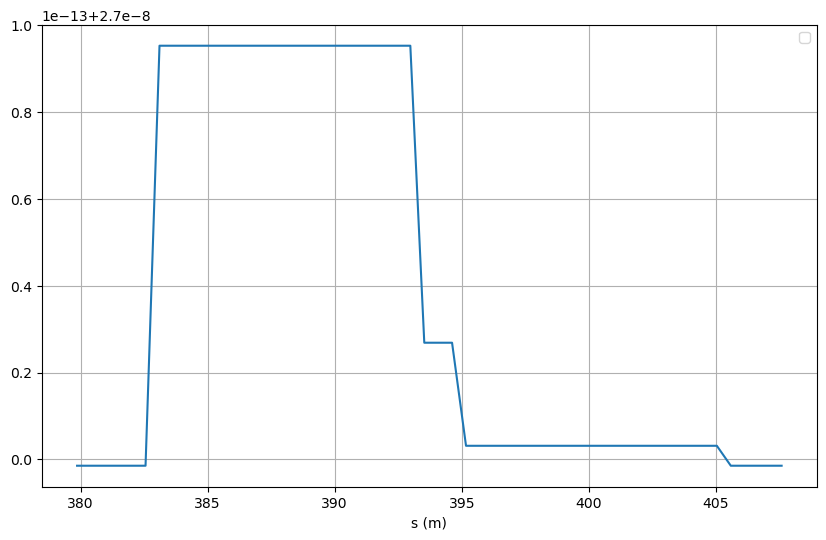

/lscratch/zihanzhu/tmp/ipykernel_3948390/3399783530.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


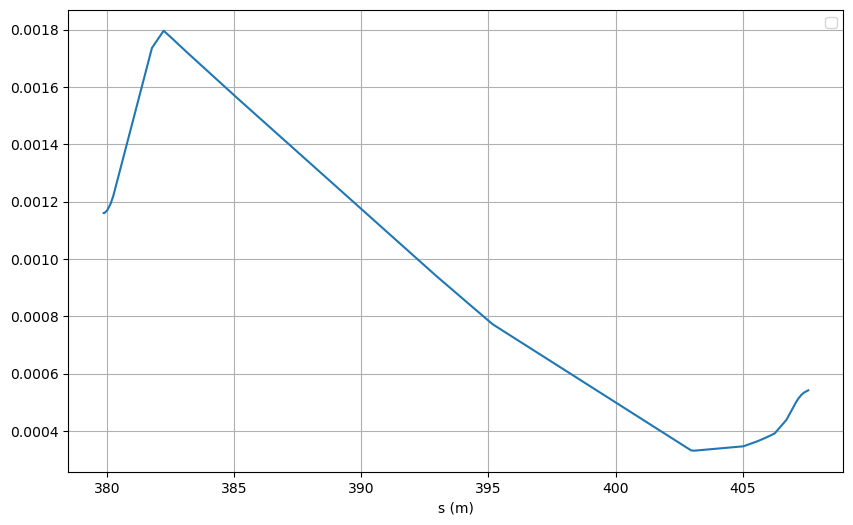

In [26]:
start_ele_name = 'begbc2'  # Adjust according to your data
end_ele_name = 'endbc2'      # Adjust according to your data


element_names = cheetah_output['ele_name']

# Find the range of indices for the specified element names
start_index = next(i for i, name in enumerate(element_names) if name == start_ele_name)
end_index = next(i for i, name in enumerate(element_names) if name == end_ele_name)

# Select the relevant subarrays
s_selected =  cheetah_output['s'][start_index:end_index + 1]
beta_x_selected =  cheetah_output['beta_x'][start_index:end_index + 1]
emit_x_selected =  cheetah_output['emit_x'][start_index:end_index + 1]
sigma_x_selected =  cheetah_output['sigma_x'][start_index:end_index + 1]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s_selected, emit_x_selected)
plt.xlabel('s (m)')
# plt.ylabel('Beta_x')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(s_selected, sigma_x_selected)
plt.xlabel('s (m)')
# plt.ylabel('Beta_x')
plt.legend()
plt.grid(True)
plt.show()
# plt.plot(cheetah_output['s'], cheetah_output['emit_x'], label='false')
# # plt.plot(cheetah_output0['s'], cheetah_output0['emit_x'], label='true')
# plt.legend()

### Benchmarking Cheetah with Bmad

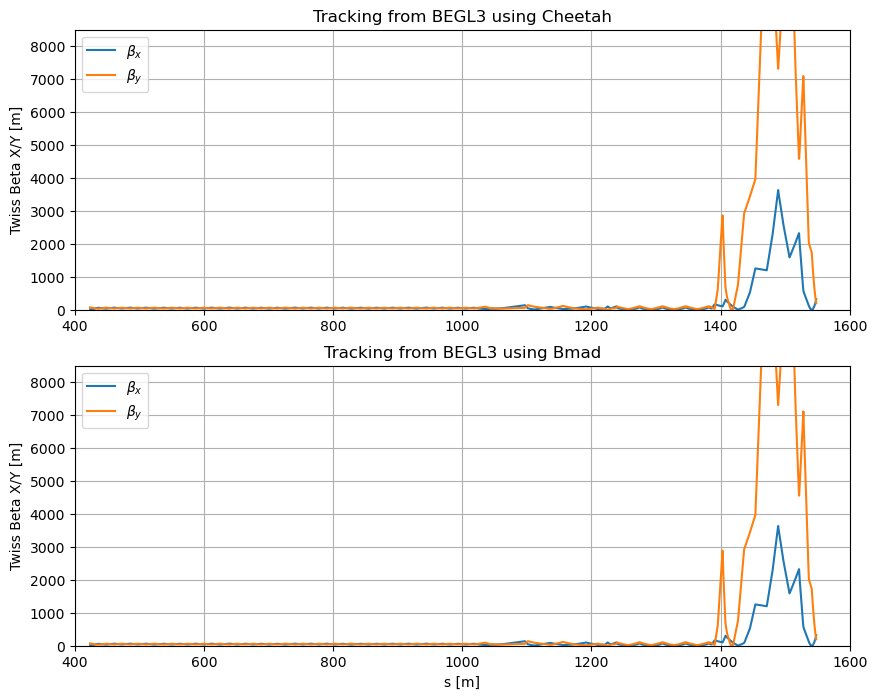

In [60]:
xlims = [400, 1600]
ylims = [0,8500]
plot_twiss_parameters(bmad_output, cheetah_output, track_start_element_name, xlims=xlims, ylims=ylims)


In [43]:
# Get some reference locations for sections
# section_beg_eles = ['LHBEG','HTRUND', 'BC1CEND','BC1CBEG', 'LHEND','WS01', 'TCAV0#1', 
            # 'K21_1C#1', 'K21_1D#1','L0B#1','L0B#3','L0B#5']#,'BC2CBEG']#,'BEGL3']#, 'BEGUNDH', 'BEGDMPH_1']
#section_beg_eles = ['BEGL1', 'BEGL3'] # laser heater
# section_beg_eles = ['BX11','BX12','BX13','BX14','LH_UND#1', 'LH_UND#2']
section_beg_eles = ['BX21','BEGBC2', 'ENDBC2','BX22','BX23','BX24']
sbend_eles = floorplan[floorplan['ElementType']=='SBend']['ElementName'].tolist()
section_eles = ['BEGL3', 'BEGBSYH_1','BEGLTUH','QEM1#1'] 
locations = []
for element in section_eles:
    index = [i for i, name in enumerate(bmad_output['ele.name']) if name == element]   
    if index:
        location = bmad_output['ele.s'][index[0]]
        locations.append((element, location))
    else:
        locations.append((element, None))
locations

[('BEGL3', np.float64(423.734659665777)),
 ('BEGBSYH_1', np.float64(1096.2961516657742)),
 ('BEGLTUH', np.float64(1209.3570846657733)),
 ('QEM1#1', np.float64(1386.0985856740517))]

### Beta function

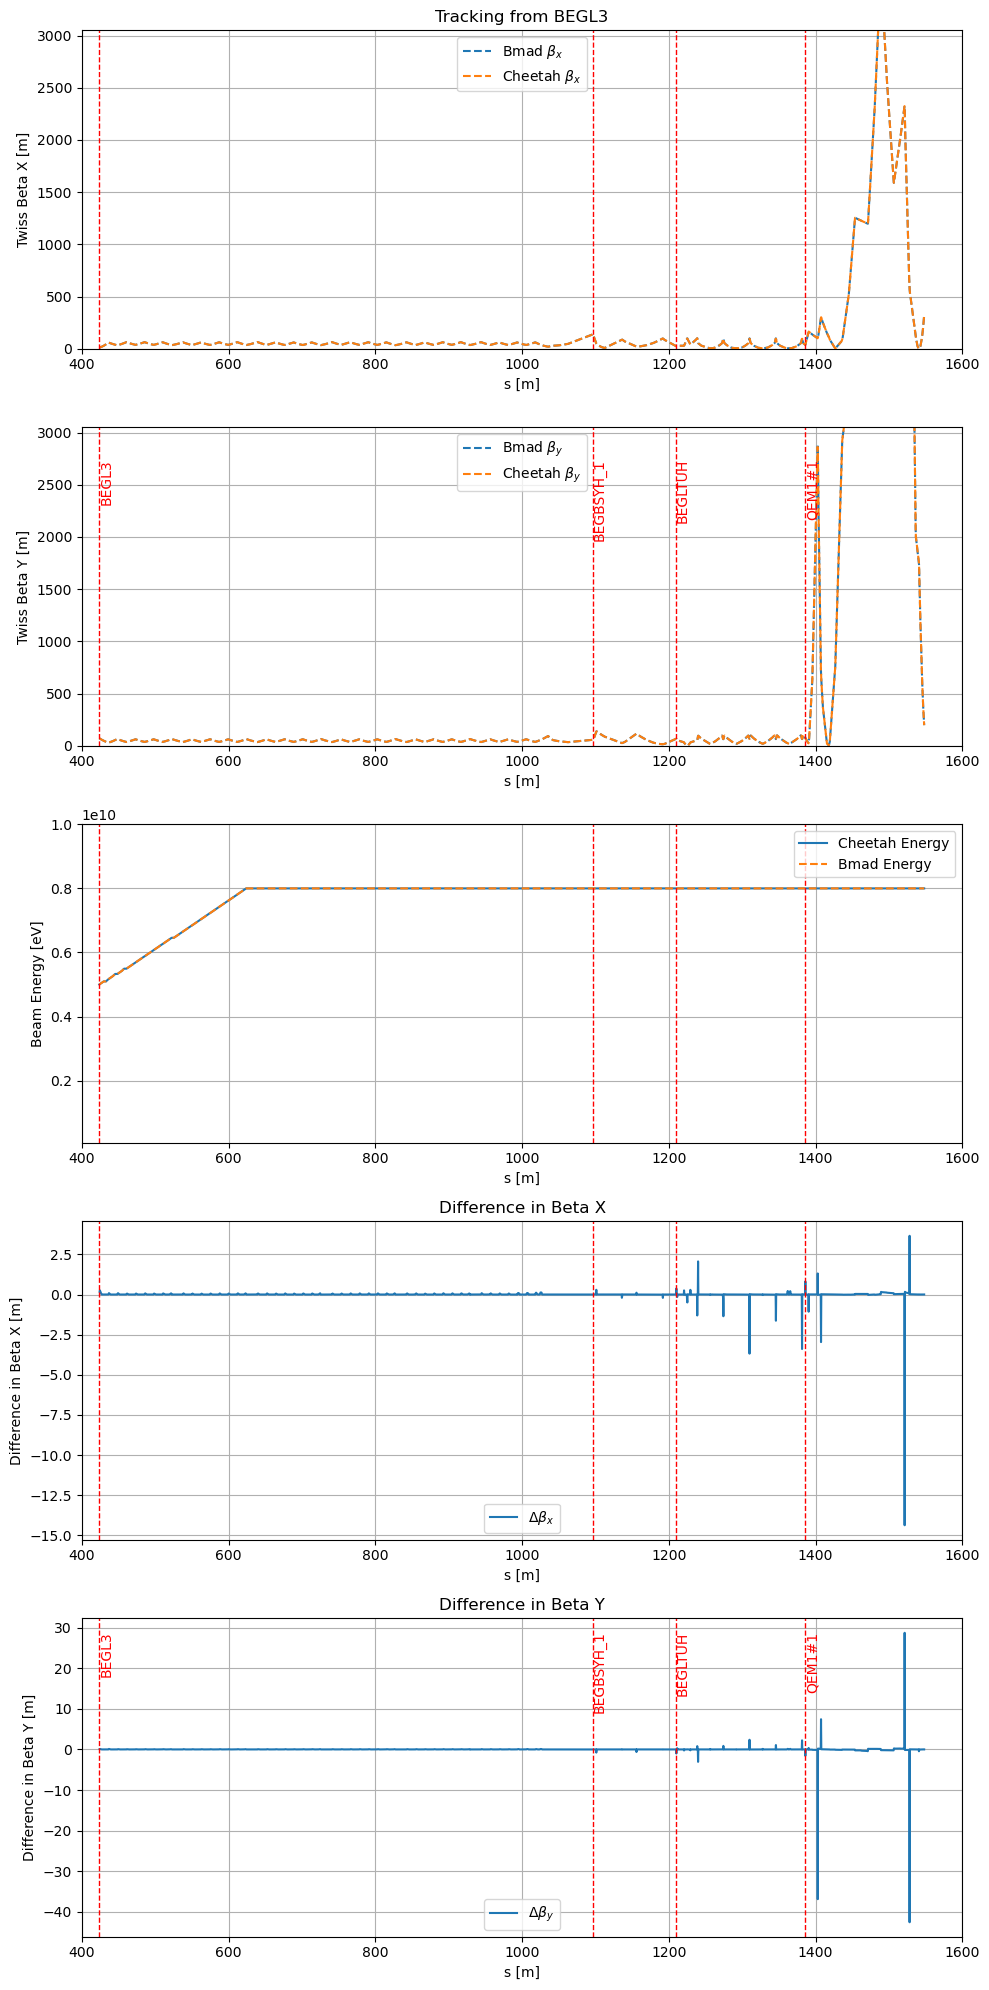

In [57]:
plot_twiss_comparison(bmad_output, cheetah_output, track_start_element_name, track_end_element_name, locations, xlims=[400, 1600], ylims=[0, 3050], energy_lims=[0.06e9, 10e9])


In [24]:
# Get some reference locations for sections
section_beg_eles = ['BEGCLTH_0','BEGBSYH_1','BEGLTUH', 'BEGUNDH', 'BEGDMPH_1']
sbend_eles = floorplan[floorplan['ElementType']=='SBend']['ElementName'].tolist()
locations = []
for element in section_beg_eles:
    index = [i for i, name in enumerate(bmad_output['ele.name']) if name == element]   
    if index:
        location = bmad_output['ele.s'][index[0]]
        locations.append((element, location))
    else:
        locations.append((element, None))
locations

[('BEGCLTH_0', np.float64(1027.3396596657747)),
 ('BEGBSYH_1', np.float64(1096.2961516657742)),
 ('BEGLTUH', np.float64(1209.3570846657733)),
 ('BEGUNDH', None),
 ('BEGDMPH_1', None)]

/sdf/home/z/zihanzhu/miniconda3/envs/lcls-live/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


NameError: name 'xlims' is not defined

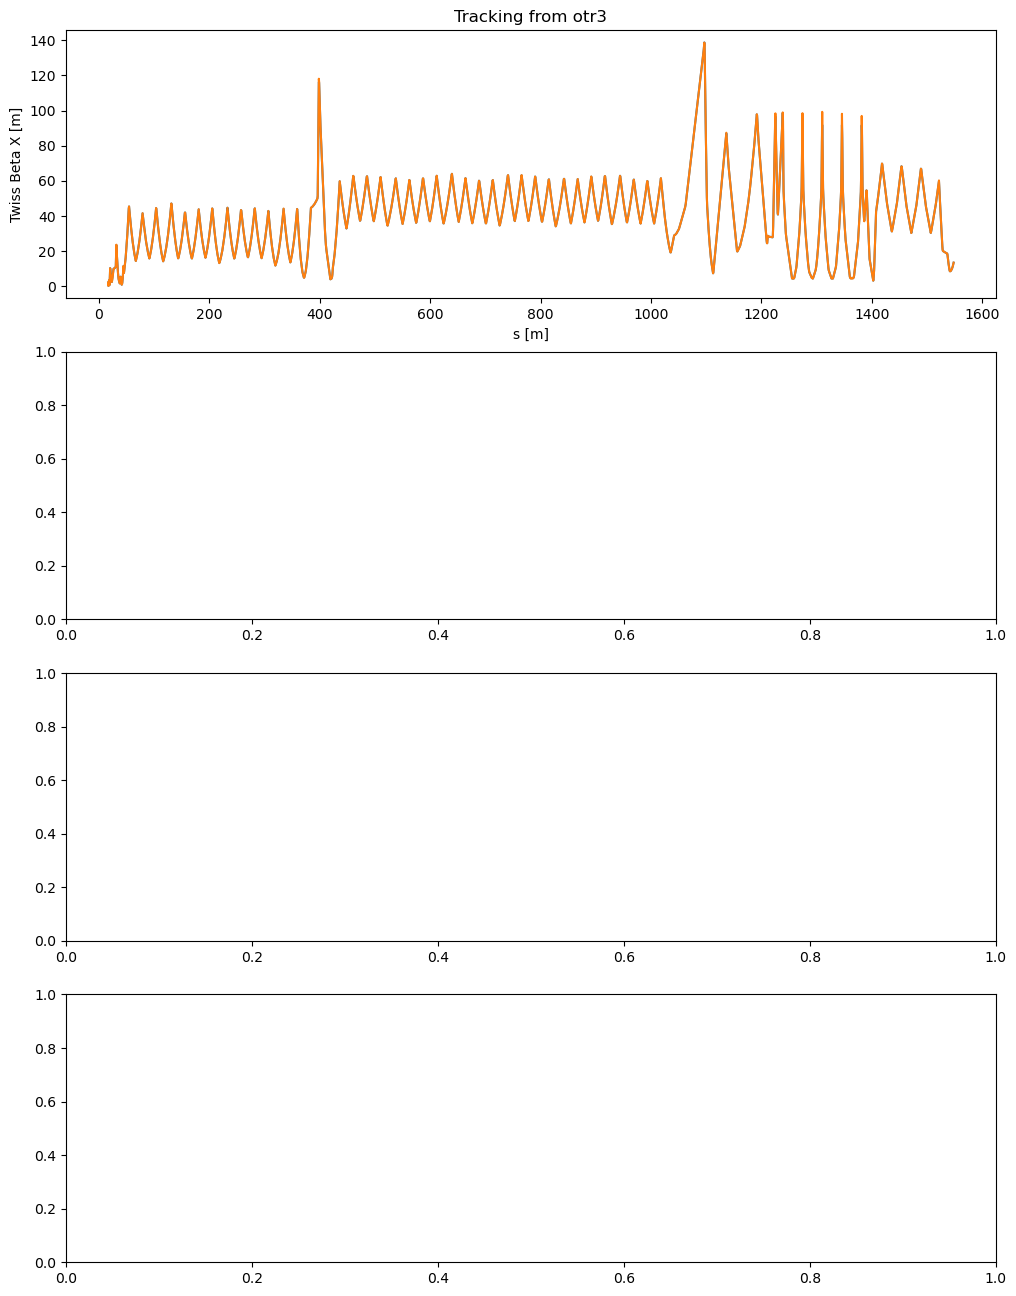

In [28]:
from scipy.interpolate import interp1d

s = cheetah_output['s']
cheetah_beta_x = cheetah_output['beta_x']
cheetah_beta_y = cheetah_output['beta_y']
cheetah_energy = cheetah_output['energy']

s_np = np.array([tensor.cpu().item() if tensor.numel() == 1 else tensor.cpu().numpy() for tensor in s])

# Define a common set of points based on x-axis limits
common_s = np.linspace(bmad_output['ele.s'][bmad_start_index[0]], bmad_output['ele.s'][bmad_end_index[0]], num=3000)

# Interpolate the curves
cheetah_interp_x = interp1d(s_np + bmad_output['ele.s'][bmad_start_index[0]], np.array(cheetah_beta_x).flatten(), kind='linear', fill_value='extrapolate')
bmad_interp_x = interp1d(bmad_output['ele.s'], bmad_output['ele.a.beta'], kind='linear', fill_value='extrapolate')

cheetah_interp_y = interp1d(s_np + bmad_output['ele.s'][bmad_start_index[0]], np.array(cheetah_beta_y).flatten(), kind='linear', fill_value='extrapolate')
bmad_interp_y = interp1d(bmad_output['ele.s'], bmad_output['ele.b.beta'], kind='linear', fill_value='extrapolate')

# Calculate the difference at common points
difference_x = cheetah_interp_x(common_s) - bmad_interp_x(common_s)
difference_y = cheetah_interp_y(common_s) - bmad_interp_y(common_s)

ylims_gap = [-10, 10]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))  

ax1.set_title(f'Tracking from {track_start_element_name}')
ax1.plot(common_s, cheetah_interp_x(common_s), label=r'cheetah')
ax1.plot(common_s, bmad_interp_x(common_s), label=r'bmad')
ax1.set_xlabel('s [m]')
ax1.set_ylabel('Twiss Beta X [m]')
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.grid()
ax1.legend()

ax2.set_xlabel('s [m]')
ax2.set_ylabel('Twiss Beta Y [m]')
ax2.plot(common_s, cheetah_interp_y(common_s), label=r'cheetah')
ax2.plot(common_s, bmad_interp_y(common_s), label=r'bmad')
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax2.grid()
ax2.legend()

# Plot the differences
ax3.set_xlabel('s [m]')
ax3.set_ylabel('Difference in Beta X [m]')
ax3.plot(common_s, difference_x, label='Difference (cheetah - bmad)', color='g')
ax3.set_xlim(xlims)
ax3.set_ylim(ylims_gap)
ax3.grid()
ax3.legend()

ax4.set_xlabel('s [m]')
ax4.set_ylabel('Difference in Beta Y [m]')
ax4.plot(common_s, difference_y, label='Difference (cheetah - bmad)', color='g')
ax4.set_xlim(xlims)
ax4.set_ylim(ylims_gap)
ax4.grid()
ax4.legend()

for element, location in locations:
    if location is not None:
        ax2.axvline(x=location, color='red', linestyle='--', linewidth=1)
        ax2.text(location, ax2.get_ylim()[1] * 0.9, element, rotation=90, verticalalignment='top', color='red')
        ax4.axvline(x=location, color='red', linestyle='--', linewidth=1)
        ax4.text(location, ax4.get_ylim()[1] * 0.9, element, rotation=90, verticalalignment='top', color='red')

plt.tight_layout()
plt.show()


In [98]:
condition = (42 < s + bmad_output['ele.s'][bmad_start_index]) & (s + bmad_output['ele.s'][bmad_start_index] < 55)
matching_indices = np.where(condition)[0]
for idx in matching_indices:
    print(f"beta_x of element {cheetah_ele_name[idx-1]} at s {s[idx] + bmad_output['ele.s'][bmad_start_index]}: {cheetah_beta_y[idx]}")

In [32]:
tracking_segment.bx01.e1 = torch.tensor([0.1527], dtype=torch.float64)
tracking_segment.bx01.e2 = torch.tensor([0.1527], dtype=torch.float64)

In [21]:
tracking_segment.bxh1?

Object `tracking_segment.bxh1` not found.


In [22]:
tc('show ele ',verbose=True)

RuntimeError: Command: show ele *IN20:381 causes error: ERROR detected: [ERROR | 2024-OCT-07 14:27:49] lat_ele_locator:
    NO ELEMENT ASSOCIATED WITH: *IN20
    THIS IS NOT PERMITTED IN A RANGE CONSTRUCT: *IN20:381

In [38]:
np.set_printoptions(precision=6, suppress=True)

In [29]:
map_a = tao.lat_list('lh_und#1','ele.mat6')
map_m = tao.lat_list('HTRUND','ele.mat6')
map_b = tao.lat_list('lh_und#2','ele.mat6')

In [32]:
map_b*map_m*map_a

array([1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 1.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.986494, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.986494, 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 1.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 1.      ])

In [35]:
tracking_segment.lh_und.transfer_map(torch.tensor(beam_energy))[:6,:6].numpy()

array([[1.      , 0.54    , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 1.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.54    , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 1.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 1.      , 0.000008],
       [0.      , 0.      , 0.      , 0.      , 0.      , 1.      ]])

In [34]:
map_b

array([ 1.      ,  0.27    ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  1.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.993224,  0.26939 ,  0.      ,  0.      ,
        0.      ,  0.      , -0.050136,  0.993224,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  1.      ,  0.000008,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  1.      ])

In [27]:
np.set_printoptions(precision=6, suppress=True)

ele_name = 'lh_und'
mat_from_bmad = tao.lat_list(ele_name,'ele.mat6').reshape(6,6)
mat_from_cheetah = tracking_segment.bxh1.transfer_map(torch.tensor(beam_energy))[0][:6,:6].numpy()
mat_gap = mat_from_bmad-mat_from_cheetah
print(f'Transfer matrix for {ele_name} in Bmad:\n', mat_from_bmad)
print(f'Transfer matrix  for {ele_name} in Cheetah:\n', mat_from_cheetah)
print('Gap:\n',mat_gap)
plt.imshow(mat_gap, cmap='viridis', interpolation='none')
plt.colorbar()

ValueError: cannot reshape array of size 0 into shape (6,6)

In [43]:
fringe_type = 'full'
tc(f'set ele BXH1 FRINGE_TYPE={fringe_type}', verbose=True)
tc(f'set ele BXH2 FRINGE_TYPE={fringe_type}', verbose=True)
tc(f'set ele BXH3 FRINGE_TYPE={fringe_type}', verbose=True)
tc(f'set ele BXH4 FRINGE_TYPE={fringe_type}', verbose=True)

tensor([-1.0557], dtype=torch.float64)
Transfer matrix for bxh1 in Bmad:
 [[ 0.991339  0.1244    0.        0.      ]
 [ 0.        1.008737  0.        0.      ]
 [ 0.        0.        1.001669  0.12476 ]
 [ 0.        0.       -0.112749  0.984291]]
Transfer matrix  for bxh1 in Cheetah:
 [[ 0.991339  0.1244    0.        0.      ]
 [-0.138644  0.991339  0.        0.      ]
 [ 0.        0.        1.        0.12476 ]
 [ 0.        0.        0.        1.      ]]
Gap:
 [[ 0.        0.        0.        0.      ]
 [ 0.138644  0.017398  0.        0.      ]
 [ 0.        0.        0.001669  0.      ]
 [ 0.        0.       -0.112749 -0.015709]]


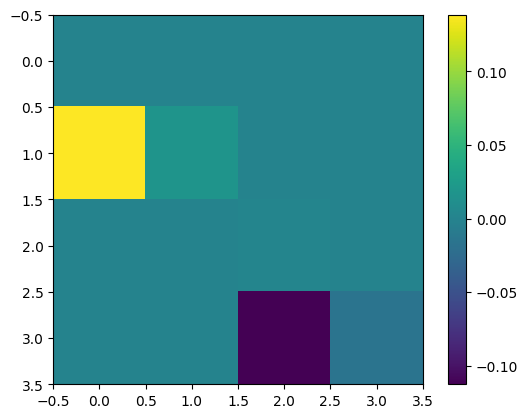

In [44]:
np.set_printoptions(precision=6, suppress=True)

ele_name = 'bxh1'
mat_from_bmad = tao.lat_list(ele_name,'ele.mat6').reshape(6,6)[:4, :4]
mat_from_cheetah = tracking_segment.bxh1.transfer_map(torch.tensor(beam_energy))[0][:4,:4].numpy()
mat_gap = mat_from_bmad-mat_from_cheetah
print(f'Transfer matrix for {ele_name} in Bmad:\n', mat_from_bmad)
print(f'Transfer matrix  for {ele_name} in Cheetah:\n', mat_from_cheetah)
print('Gap:\n',mat_gap)
plt.imshow(mat_gap, cmap='viridis', interpolation='none')
plt.colorbar()

tensor([-1.0557], dtype=torch.float64)
Transfer matrix for bxh1 in Bmad:
 [[ 0.991339  0.1244    0.        0.        0.       -0.008204]
 [ 0.        1.008737  0.        0.        0.       -0.132476]
 [ 0.        0.        1.001669  0.12476   0.        0.      ]
 [ 0.        0.       -0.112749  0.984291  0.        0.      ]
 [ 0.131329  0.008204  0.        0.        1.       -0.000359]
 [ 0.        0.        0.        0.        0.        1.      ]]
Transfer matrix  for bxh1 in Cheetah:
 [[ 0.991339  0.1244    0.        0.        0.       -0.008204]
 [-0.138644  0.991339  0.        0.        0.       -0.13133 ]
 [ 0.        0.        1.        0.12476   0.        0.      ]
 [ 0.        0.        0.        1.        0.        0.      ]
 [-0.13133  -0.008204  0.        0.        1.        0.000359]
 [ 0.        0.        0.        0.        0.        1.      ]]
Gap:
 [[ 0.        0.        0.        0.        0.        0.      ]
 [ 0.138644  0.017398  0.        0.        0.       -0.00114

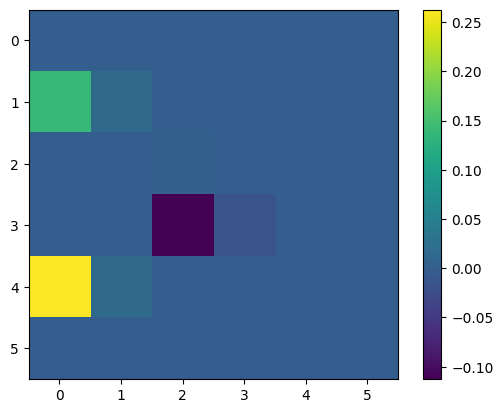

In [45]:
np.set_printoptions(precision=6, suppress=True)

ele_name = 'bxh1'
mat_from_bmad = tao.lat_list(ele_name,'ele.mat6').reshape(6,6)[:6, :6]
mat_from_cheetah = tracking_segment.bxh1.transfer_map(torch.tensor(beam_energy))[0][:6,:6].numpy()
mat_gap = mat_from_bmad-mat_from_cheetah
print(f'Transfer matrix for {ele_name} in Bmad:\n', mat_from_bmad)
print(f'Transfer matrix  for {ele_name} in Cheetah:\n', mat_from_cheetah)
print('Gap:\n',mat_gap)
plt.imshow(mat_gap, cmap='viridis', interpolation='none')
plt.colorbar()

In [25]:
tao.cmd('show ele bxh1')

['Element # 2',
 'Element Name: BXH1',
 'Element Type:  "5D3.9"',
 'Element Alias:  "BEND:IN20:451"',
 'Key: SBend',
 'Sub Key: SBend',
 'S_start, S:      9.076892,      9.201652',
 'Ref_time_start, Ref_time:  3.029877E-08,  3.071493E-08',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  1.2476040E-01 m        29  L_SAGITTA                   = -2.0532723E-03 m',
 '    6  G                           = -1.0556987E+00 1/m      43  B_FIELD                     =  4.7538990E-01 T',
 '    8  G_TOT                       = -1.0556987E+00 1/m      28  B_FIELD_TOT                 =  4.7538990E-01 T',
 '    9  RHO                         = -9.4723995E-01 m',
 '   10  FRINGE_TYPE                 =  Full (4)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   14  EXACT_MULTIPOLES            =  Off (1)                31  FIDUCIAL_PT                 =  None (4)',
 '   17  STATIC_LINEAR_MAP 

In [30]:
tracking_segment.bxh1._transfer_map_enter()[0][:6,:6].numpy()

tensor([-1.0557], dtype=torch.float64)


array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.00668709,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

In [94]:
tracking_segment.bxh1.transfer_map(torch.tensor([beam_energy]))[0][:6,:6].numpy()

array([[ 0.991339,  0.1244  ,  0.      ,  0.      ,  0.      , -0.008204],
       [-0.138644,  0.991339,  0.      ,  0.      ,  0.      , -0.13133 ],
       [ 0.      ,  0.      ,  1.      ,  0.12476 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.      ,  0.      ,  0.      ],
       [-0.13133 , -0.008204,  0.      ,  0.      ,  1.      ,  0.000359],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  1.      ]])

In [29]:
tracking_segment.bxh1._transfer_map_exit()[0][:6,:6].numpy()

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.13985509,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.13287881,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

In [49]:
def linear_dipole_fringe_matrix(e, g_tot, f_int, h_gap):
    """
    Compute the 6x6 fringe field transfer matrix for the entrance or exit of a dipole.
    
    :param e: The face angle (e1 for entrance, e2 for exit).
    :param g_tot: Total field gradient.
    :param f_int: Fringe integral.
    :param h_gap: Magnet gap.
    :param entering: Boolean indicating if the fringe field is for the entrance (True) or exit (False).
    :return: 6x6 NumPy array representing the fringe field transfer matrix.
    """
    tan_e = np.tan(e)
    term = (2 * f_int * h_gap * g_tot * (1 + np.sin(e)**2)) / np.cos(e)
    
    delta_px = g_tot * tan_e
    delta_py = -g_tot * np.tan(e - term)
    
    fringe_matrix = np.eye(6)

    fringe_matrix[1, 0] = delta_px
    fringe_matrix[3, 2] = delta_py

    return fringe_matrix
    
def colleague_transfer_map_enter(e1, f_int, g_tot, h_gap):
    sec_e1 = 1.0 / np.cos(e1)
    phi = f_int * g_tot * h_gap * sec_e1 * (1 + np.sin(e1) ** 2)
    fringe_matrix = np.eye(6)
    fringe_matrix[1, 0] = g_tot * np.tan(e1)
    fringe_matrix[3, 2] = -g_tot * np.tan(e1 - phi)
    return fringe_matrix

def colleague_transfer_map_exit(e2, f_int, g_tot, h_gap):
    sec_e2 = 1.0 / np.cos(e2)
    phi = f_int * g_tot * h_gap * sec_e2 * (1 + np.sin(e2) ** 2)
    fringe_matrix = np.eye(6)
    fringe_matrix[1, 0] = g_tot * np.tan(e2)
    fringe_matrix[3, 2] = -g_tot * np.tan(e2 - phi)
    return fringe_matrix

In [50]:
e1 = tracking_segment.bxh1.e1  # Entrance face angle
e2 = tracking_segment.bxh1.e2  # Exit face angle
g_tot = (tracking_segment.bxh1.e1 + tracking_segment.bxh1.e2) / tracking_segment.bxh1.length # Example field gradient
f_int = tracking_segment.bxh1.fringe_integral  # Example fringe integral
h_gap = tracking_segment.bxh1.gap  # Example magnet gap

# Compute the transfer matrices
M_enter_bmad = linear_dipole_fringe_matrix(e1, g_tot, f_int, h_gap)
M_exit_bmad = linear_dipole_fringe_matrix(e2, g_tot, f_int, h_gap)

# Assuming map_m is the main dipole body matrix, defined similarly as np.array
map_m_bmad = np.array([[ 0.991339,  0.1244,    0.,        0.,        0.,       -0.008204],
 [-0.138644,  0.991339 , 0. ,       0.    ,    0. ,      -0.131329],
 [ 0. ,       0.  ,      1.  ,      0.12476,   0.  ,      0.      ],
 [ 0. ,       0.     ,   0.  ,      1.  ,      0.  ,      0.      ],
 [ 0.131329,  0.008204 , 0. ,       0.  ,      1.  ,     -0.000359],
 [ 0.   ,     0.   ,     0.  ,      0.  ,      0.   ,     1.      ]])  # Placeholder for the actual body matrix

# Combine matrices to get the full transfer matrix
intermediate_bmad = np.matmul(map_m_bmad, M_enter_bmad)
R_Out_bmad = np.matmul(M_exit_bmad, intermediate_bmad)

print('Bmad linear_edge fringe effect implemented:')
print("Entrance Fringe Transfer Matrix M_enter:")
print(M_enter_bmad)
print("\nExit Fringe Transfer Matrix M_exit:")
print(M_exit_bmad)
print("\nFinal Combined Transfer Matrix R_Out:")
print(R_Out_bmad)


map_m_cheetah = np.array([[ 0.991339,  0.1244  ,  0.      ,  0.      ,  0.      , -0.008204],
       [-0.138644,  0.991339,  0.      ,  0.      ,  0.      , -0.13133 ],
       [ 0.      ,  0.      ,  1.      ,  0.12476 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.      ,  0.      ,  0.      ],
       [-0.13133 , -0.008204,  0.      ,  0.      ,  1.      ,  0.000359],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  1.      ]])


M_enter_cheetah = colleague_transfer_map_enter(e1,f_int, g_tot, h_gap)
M_exit_cheetah = colleague_transfer_map_exit(e2,f_int, g_tot, h_gap)
intermediate_cheetah = np.matmul(map_m_cheetah, M_enter_cheetah)
R_Out_cheetah = np.matmul(M_exit_cheetah, intermediate_cheetah)

print('\nCheetah linear_edge fringe effect implemented:')
print("Entrance Fringe Transfer Matrix M_enter:")
print(M_enter_cheetah)
print("\nExit Fringe Transfer Matrix M_exit:")
print(M_exit_cheetah)
print("\nFinal Combined Transfer Matrix R_Out:")
print(R_Out_cheetah)


Bmad linear_edge fringe effect implemented:
Entrance Fringe Transfer Matrix M_enter:
[[ 1.        0.        0.        0.        0.        0.      ]
 [-0.        1.        0.        0.        0.        0.      ]
 [ 0.        0.        1.        0.        0.        0.      ]
 [ 0.        0.        0.013375  1.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.      ]
 [ 0.        0.        0.        0.        0.        1.      ]]

Exit Fringe Transfer Matrix M_exit:
[[ 1.        0.        0.        0.        0.        0.      ]
 [ 0.139855  1.        0.        0.        0.        0.      ]
 [ 0.        0.        1.        0.        0.        0.      ]
 [ 0.        0.       -0.125914  1.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.      ]
 [ 0.        0.        0.        0.        0.        1.      ]]

Final Combined Transfer Matrix R_Out:
[[ 0.991339  0.1244    0.        0.        0.       -0.008204]
 [-0.        1.008

/lscratch/zihanzhu/tmp/ipykernel_2407036/3342016528.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tan_e = np.tan(e)
/lscratch/zihanzhu/tmp/ipykernel_2407036/3342016528.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  term = (2 * f_int * h_gap * g_tot * (1 + np.sin(e)**2)) / np.cos(e)
/lscratch/zihanzhu/tmp/ipykernel_2407036/3342016528.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  delta_py = -g_tot * np.tan(e - term)
/lscratch/zihanzhu/tmp/ipykernel_2407036/3342016528.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sec_e1 = 1.0 / np.cos(e1)
/lscratch/zihanzhu/tmp/ipykernel_2407036/3342016528.py:27: Depr

In [37]:
g_tot

tensor([-1.0557], dtype=torch.float64)

In [ ]:
 [[ 0.991339  0.1244    0.        0.        0.       -0.008204]
 [ 0.        1.008737  0.        0.        0.       -0.132476]
 [ 0.        0.        1.001669  0.12476   0.        0.      ]
 [ 0.        0.       -0.112749  0.984291  0.        0.      ]
 [ 0.131329  0.008204  0.        0.        1.       -0.000359]
 [ 0.        0.        0.        0.        0.        1.      ]]

In [37]:
print(tracking_segment.bxh1)
out_bxh1_cheetah = tracking_segment.bxh1.track(design_incoming)
out_bxh1_cheetah

Dipole(length=tensor([0.1248], dtype=torch.float64), angle=tensor([-0.1317], dtype=torch.float64), k1=tensor([0.], dtype=torch.float64), e1=tensor([0.], dtype=torch.float64),e2=tensor([-0.1317], dtype=torch.float64),tilt=tensor([0.], dtype=torch.float64),gap=tensor([0.0150], dtype=torch.float64),gap_exit=tensor([0.0150], dtype=torch.float64),fringe_integral=tensor([0.4000], dtype=torch.float64),fringe_integral_exit=tensor([0.4000], dtype=torch.float64),fringe_at='both',fringe_type='linear_edge',tracking_method='cheetah', name='bxh1')


ParticleBeam(n=10000, mu_x=tensor([-1.5079e-05], dtype=torch.float64), mu_px=tensor([1.5254e-05], dtype=torch.float64), mu_y=tensor([2.0899e-05], dtype=torch.float64), mu_py=tensor([4.3745e-06], dtype=torch.float64), sigma_x=tensor([0.0009], dtype=torch.float64), sigma_px=tensor([0.0019], dtype=torch.float64), sigma_y=tensor([0.0058], dtype=torch.float64), sigma_py=tensor([0.0003], dtype=torch.float64), sigma_tau=tensor([0.0001], dtype=torch.float64), sigma_p=tensor([9.9059e-07], dtype=torch.float64), energy=tensor([1.3500e+08], dtype=torch.float64)) total_charge=tensor([2.5000e-10], dtype=torch.float64))

In [38]:
tracking_segment.bxh1.tracking_method = 'bmadx'

In [39]:
print(tracking_segment.bxh1)
out_bxh1_bmadx = tracking_segment.bxh1.track(design_incoming)
out_bxh1_bmadx

Dipole(length=tensor([0.1248], dtype=torch.float64), angle=tensor([-0.1317], dtype=torch.float64), k1=tensor([0.], dtype=torch.float64), e1=tensor([0.], dtype=torch.float64),e2=tensor([-0.1317], dtype=torch.float64),tilt=tensor([0.], dtype=torch.float64),gap=tensor([0.0150], dtype=torch.float64),gap_exit=tensor([0.0150], dtype=torch.float64),fringe_integral=tensor([0.4000], dtype=torch.float64),fringe_integral_exit=tensor([0.4000], dtype=torch.float64),fringe_at='both',fringe_type='linear_edge',tracking_method='bmadx', name='bxh1')


ParticleBeam(n=10000, mu_x=tensor([-1.4901e-05], dtype=torch.float64), mu_px=tensor([1.5561e-05], dtype=torch.float64), mu_y=tensor([2.0900e-05], dtype=torch.float64), mu_py=tensor([4.3744e-06], dtype=torch.float64), sigma_x=tensor([0.0009], dtype=torch.float64), sigma_px=tensor([0.0019], dtype=torch.float64), sigma_y=tensor([0.0058], dtype=torch.float64), sigma_py=tensor([0.0003], dtype=torch.float64), sigma_tau=tensor([0.0001], dtype=torch.float64), sigma_p=tensor([9.9059e-07], dtype=torch.float64), energy=tensor([1.3500e+08], dtype=torch.float64)) total_charge=tensor([2.5000e-10], dtype=torch.float64))

In [28]:
tao.lat_list('k21_3b','ele.PHI0')*360

array([-33.5])

In [34]:
tao.lat_list('K21_3b', "ele.FRINGE_AT" )

array([3.])

In [7]:
tao.cmd('sho -lat s 00:18')

RuntimeError: Command: sho -lat s 00:18 causes error: ERROR detected: [ERROR | 2024-SEP-18 16:14:32] tao_next_switch:
    UNKNOWN SWITCH: -lat

In [84]:
tao.cmd('sho ele k25_1b')

['Element # 448',
 'Element Name: K25_1B',
 'Element Type:  "10ft"',
 'Element Alias:  "KLYS:LI25:11"',
 'Key: Lcavity',
 'S_start, S:    426.778760,    429.822860',
 'Ref_time_start, Ref_time:  1.423603E-06,  1.433757E-06',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  3.0441000E+00 m        31  L_ACTIVE                    =  3.0441000E+00 m',
 '    7  GRADIENT_ERR                =  0.0000000E+00 eV/m',
 '    8  VOLTAGE                     =  4.8198469E+07 Volt      6  GRADIENT                    =  1.5833405E+07 eV/m',
 '    9  VOLTAGE_ERR                 =  0.0000000E+00 Volt',
 '   10  FRINGE_TYPE                 =  Full (4)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   15  RF_FREQUENCY                =  2.8560000E+09 Hz       16  RF_WAVELENGTH               =  1.0496935E-01 m',
 '   17  STATIC_LINEAR_MAP           =  F (0)',
 '   18  LONGITUDINAL_MODE          

In [35]:
tc('sho ele K21_7D',verbose=True)

Element # 321
Element Name: K21_7D
Element Type:  "10ft"
Element Alias:  "KLYS:LI21:71"
Key: Lcavity
S_start, S:    100.519374,    103.563474
Ref_time_start, Ref_time:  3.353187E-07,  3.454727E-07

Attribute values [Only non-zero values shown]:
    1  L                           =  3.0441000E+00 m        31  L_ACTIVE                    =  3.0441000E+00 m
    7  GRADIENT_ERR                =  0.0000000E+00 eV/m
    8  VOLTAGE                     =  5.1449447E+07 Volt      6  GRADIENT                    =  1.6901365E+07 eV/m
    9  VOLTAGE_ERR                 =  0.0000000E+00 Volt
   10  FRINGE_TYPE                 =  Full (4)               11  FRINGE_AT                   =  Both_Ends (3)
   13  SPIN_FRINGE_ON              =  T (1)
   15  RF_FREQUENCY                =  2.8560000E+09 Hz       16  RF_WAVELENGTH               =  1.0496935E-01 m
   17  STATIC_LINEAR_MAP           =  F (0)
   18  LONGITUDINAL_MODE           = 0
   19  AUTOSCALE_AMPLITUDE         =  T (1)                  20  

In [26]:
quad_length = torch.tensor([0.124])
segment = cheetah.Segment(elements=
    [
        cheetah.Drift(torch.tensor([0.292]), name="D0H00C"),
        cheetah.Quadrupole(quad_length,name="Q0H01"),
        cheetah.Drift(torch.tensor([0.428])),
        cheetah.Quadrupole(quad_length,name="Q0H02"),
        cheetah.Drift(torch.tensor([0.4179])),
        cheetah.Quadrupole(quad_length,name="Q0H03"),
        cheetah.Drift(torch.tensor([0.41])),
        cheetah.Quadrupole(quad_length,name="Q0H04"),
        cheetah.Drift(torch.tensor([0.248])),
        cheetah.Marker(name = 'OTR0H04')
    ]
)
trasfer_map = segment.transfer_map(torch.tensor([9e7]))

In [21]:
tao.cmd('show ele Q26201')

['Element # 3222',
 'Element Name: Q26201',
 'Element Type:  "QE"',
 'Element Alias:  "QUAD:LI26:201"',
 'Key: Quadrupole',
 'S_start, S:    537.545260,    537.652060',
 'Ref_time_start, Ref_time:  1.793080E-06,  1.793436E-06',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  1.0680000E-01 m',
 '    4  K1                          =  3.8884413E-01 1/m^2    45  B1_GRADIENT                 = -8.6259197E+00 T/m',
 '   10  FRINGE_TYPE                 =  None (1)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   17  STATIC_LINEAR_MAP           =  F (0)',
 '   47  PTC_CANONICAL_COORDS        =  T (1)',
 '   53  P0C                         =  6.6504428E+09 eV           BETA                        =  1.0000000E+00',
 '   54  E_TOT                       =  6.6504429E+09 eV           GAMMA                       =  1.3014592E+04',
 '   64  REF_TIME_START              =  1.7930802E-06 

In [24]:
# Get some reference locations for sections
scan_eles = ['Q26201#1'] 
locations = []
for element in scan_eles:
    index = [i for i, name in enumerate(bmad_output['ele.name']) if name == element]   
    if index:
        location = bmad_output['ele.s'][index[0]]
        locations.append((element, location))
    else:
        locations.append((element, None))
locations

[('Q26201#1', 537.5986596657773)]

In [25]:
scan_range = np.linspace(3.2E-01, 4.6E-01, 10) # nominal setting 3.8884413E-01 for Q26201 (QUAD:LI26:201) ; -4.0538118E-01 for Q26301
bmad_outputs = {}
cheetah_outputs = {}
for scan_value in scan_range:
    # run Bmad
    tc(f'set ele Q26201 K1={scan_value}')
    tc('set global track_type = single')
    O_scan = get_output(tao)
    bmad_outputs[scan_value] = O_scan

    #run Cheetah
    tracking_segment.q26201.k1 = torch.tensor([scan_value], dtype=torch.float64)
    s, cheetah_beta_x, cheetah_beta_y, cheetah_mu_x, cheetah_mu_y, cheetah_ele_name = get_cheetah_beam_values(tracking_segment, design_incoming)
    cheetah_outputs[scan_value] = {
        's': s,
        'beta_x': cheetah_beta_x,
        'beta_y': cheetah_beta_y,
        'mu_x': cheetah_mu_x,
        'mu_y': cheetah_mu_y,
        'ele_name': cheetah_ele_name
    }

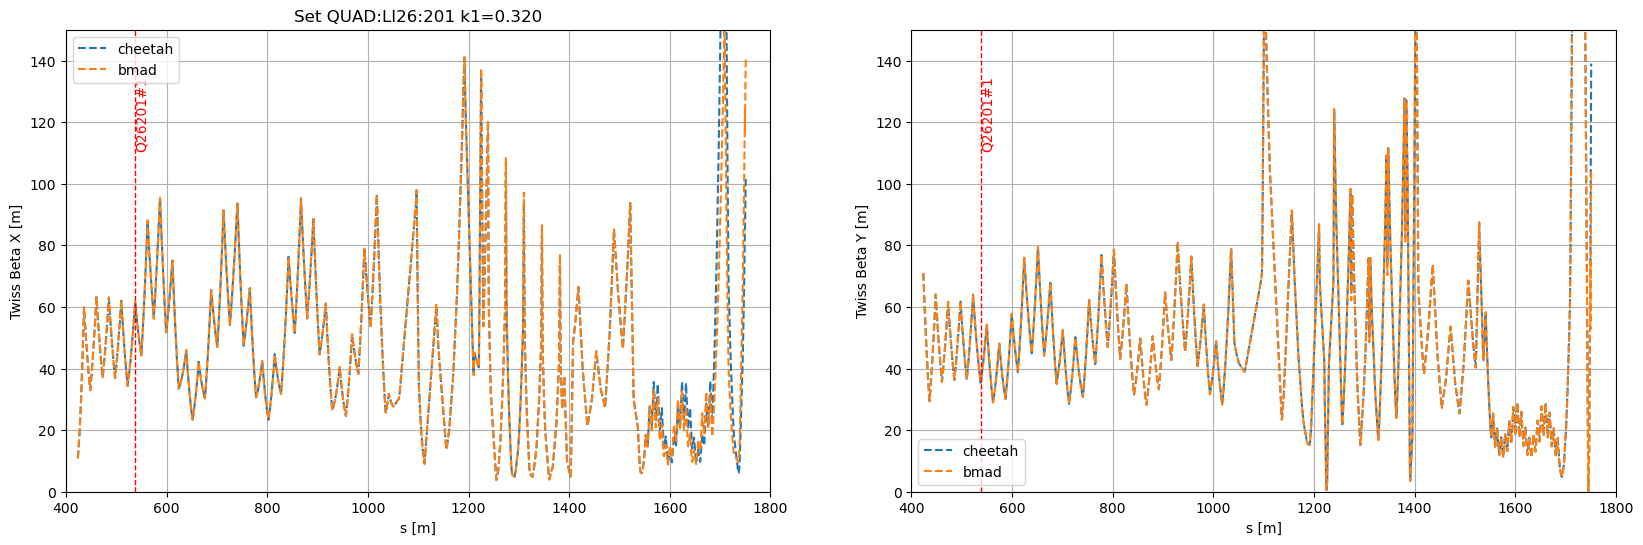

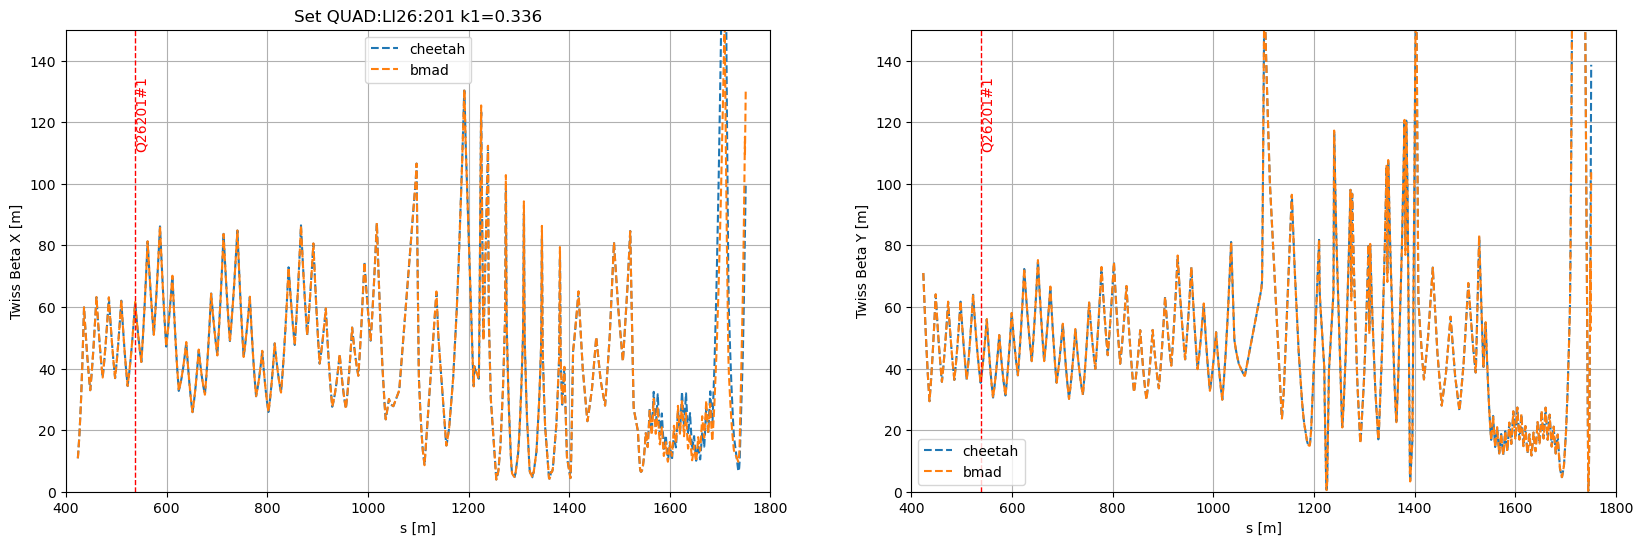

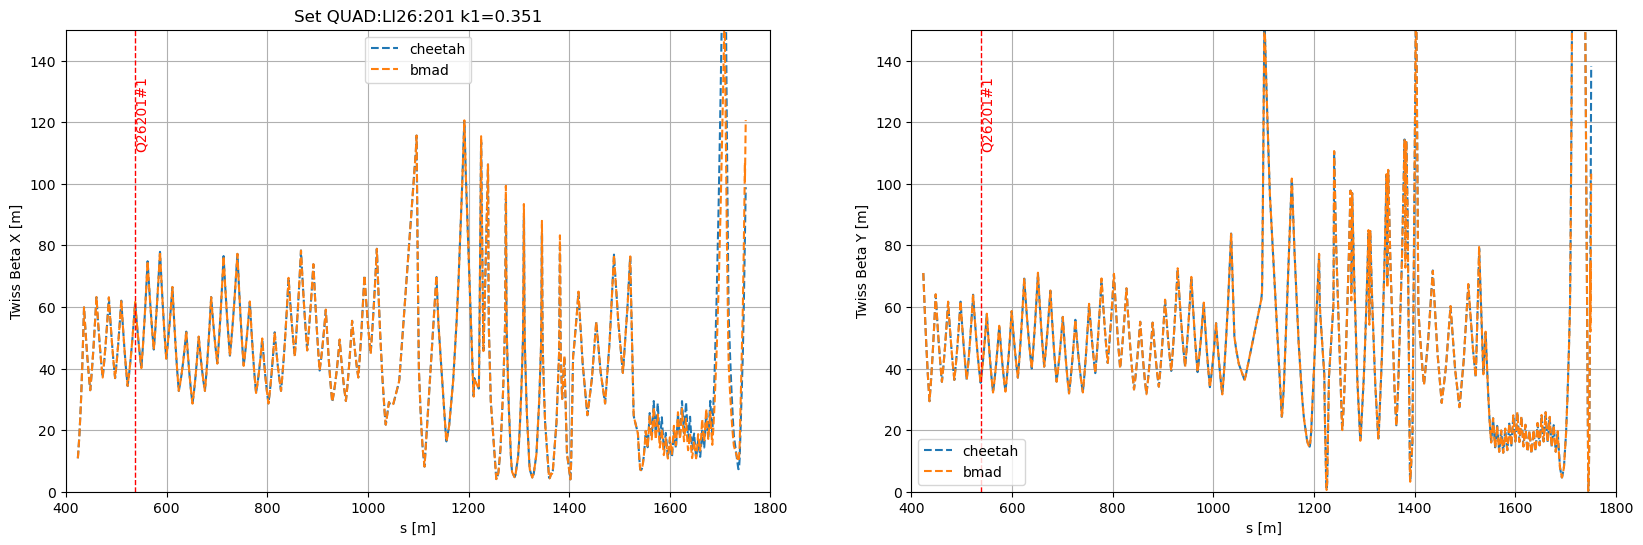

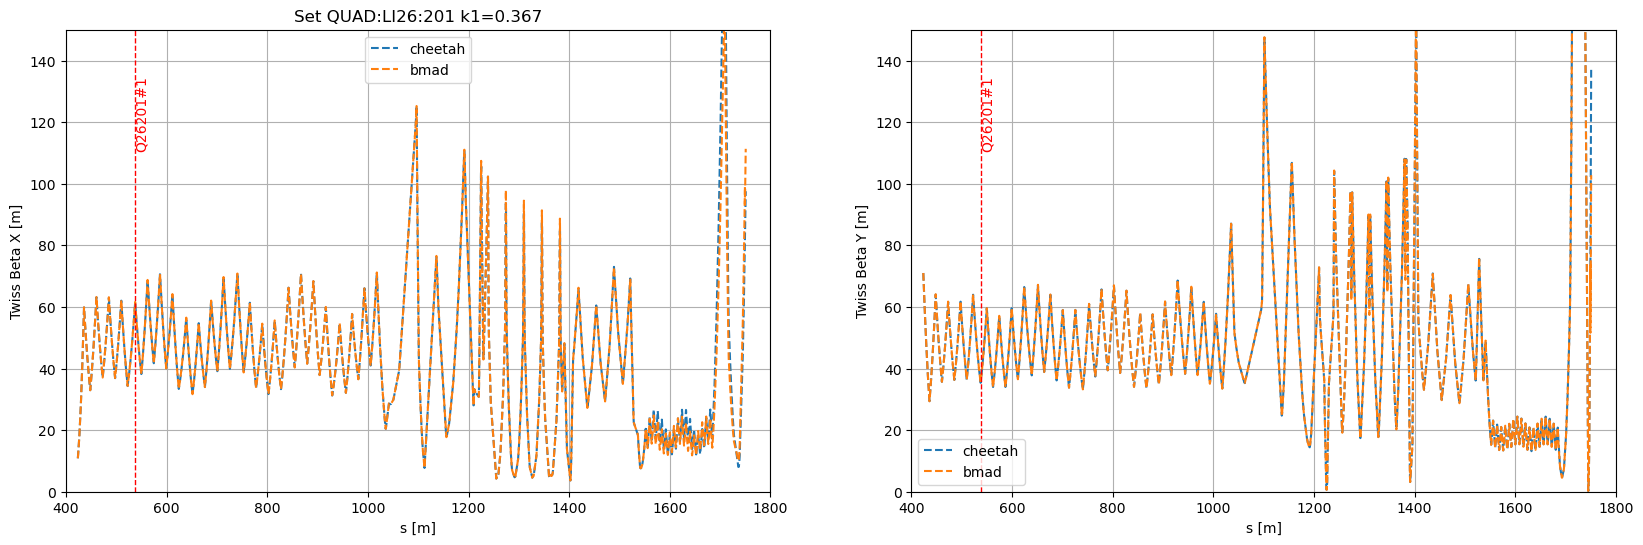

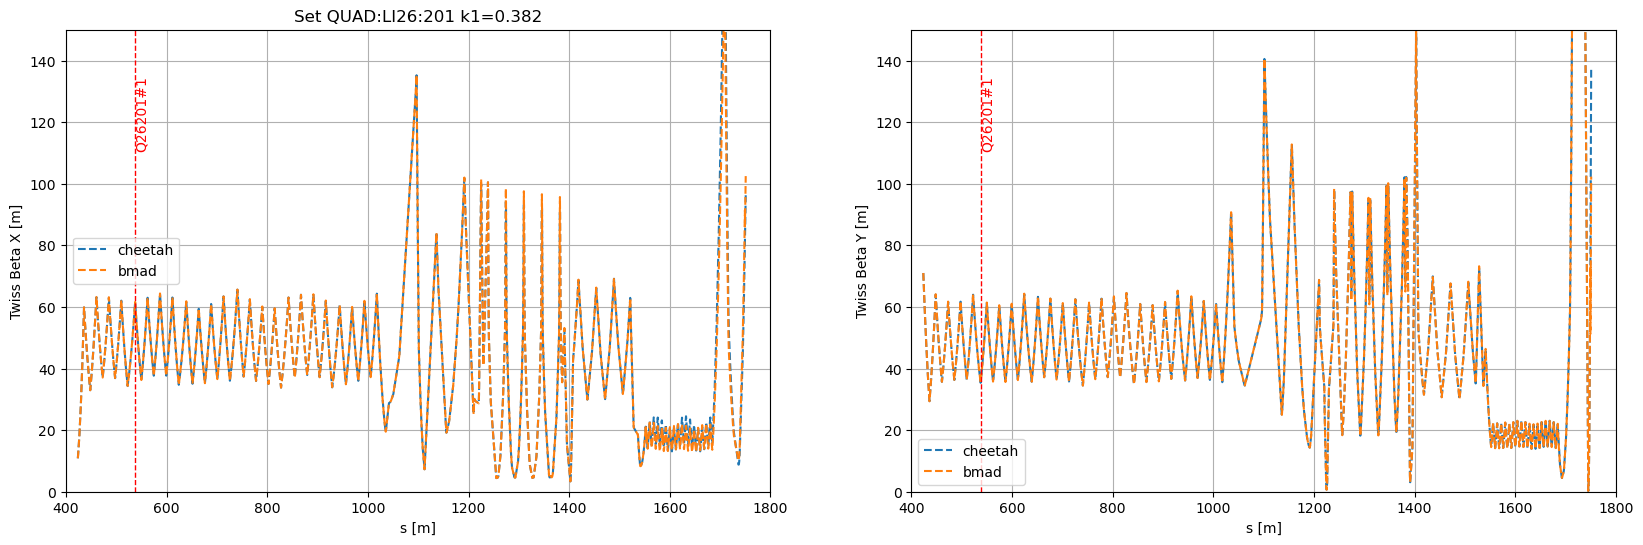

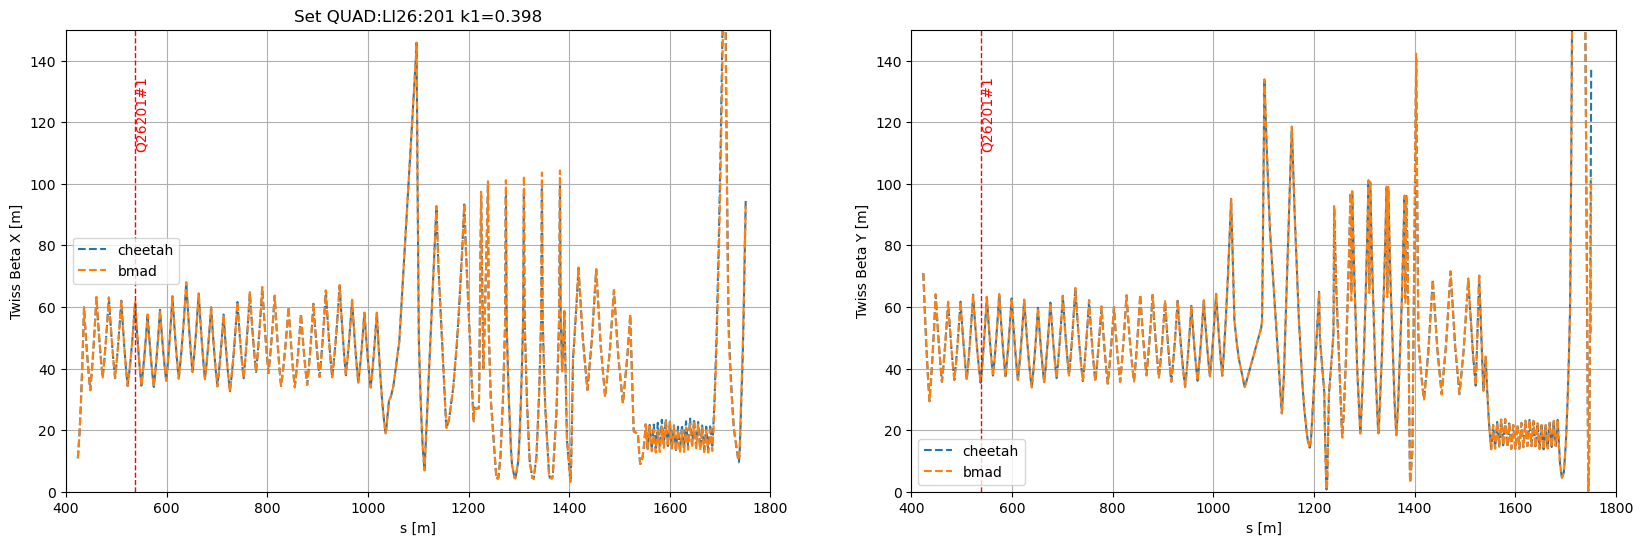

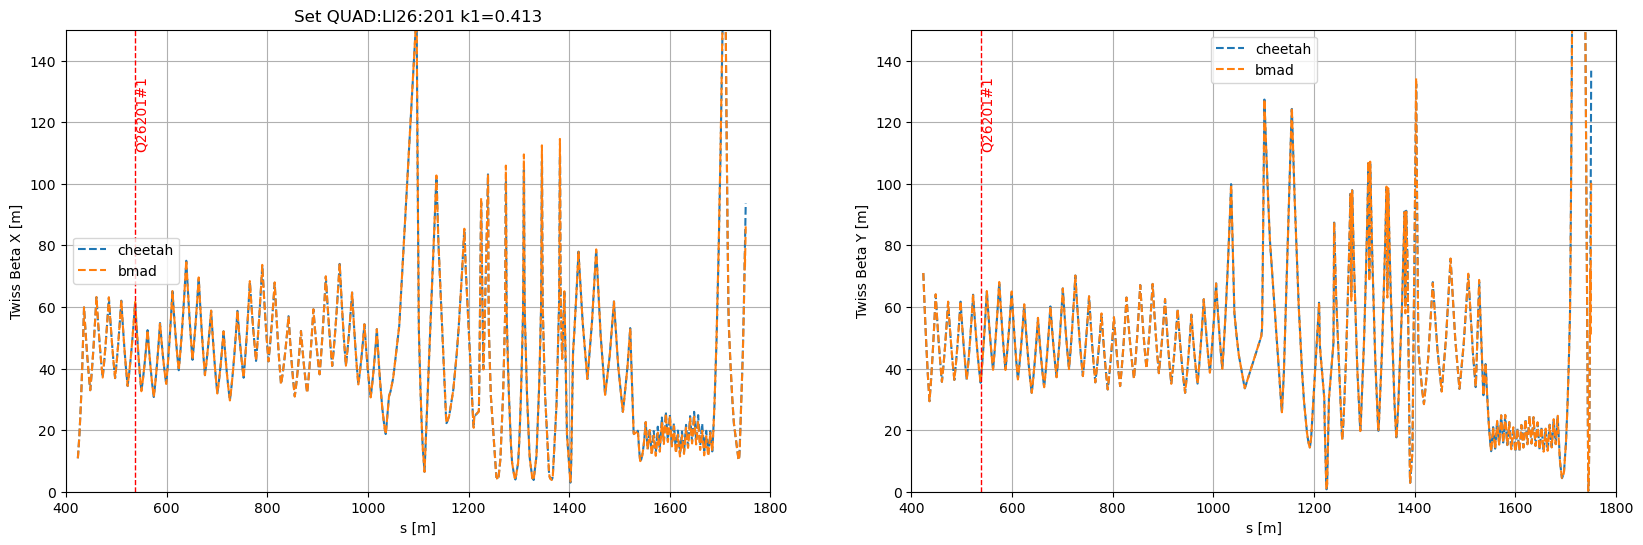

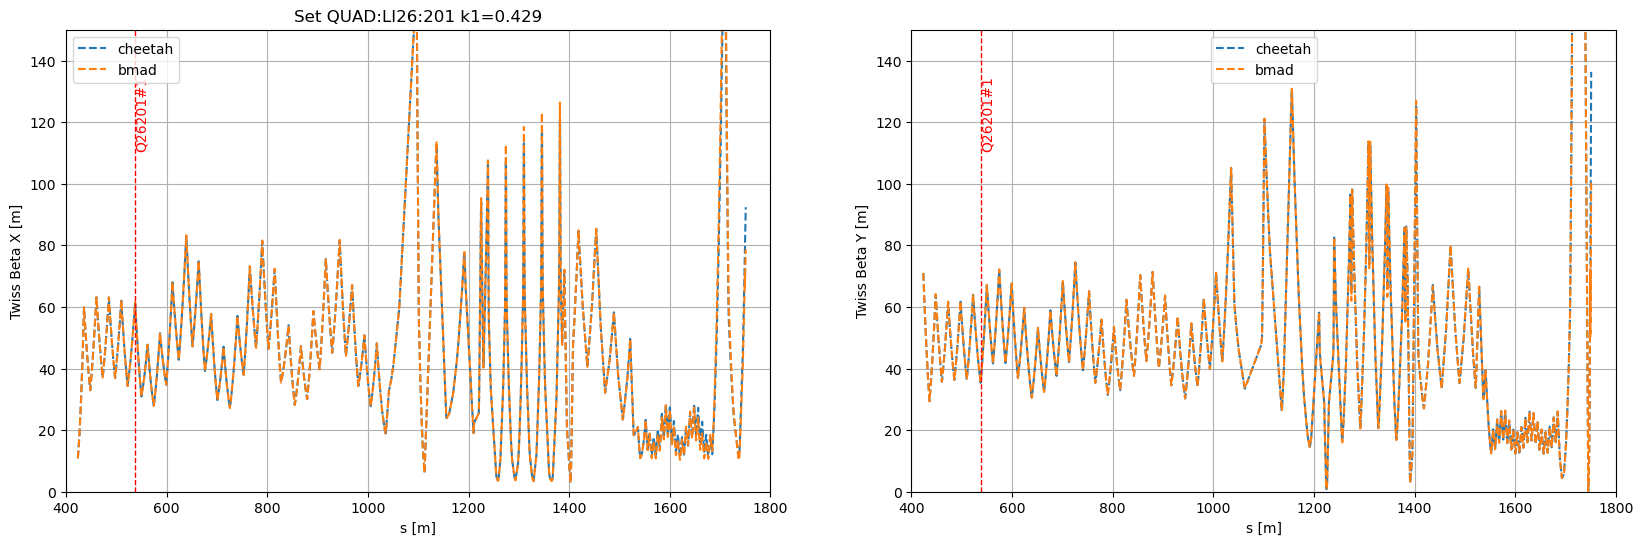

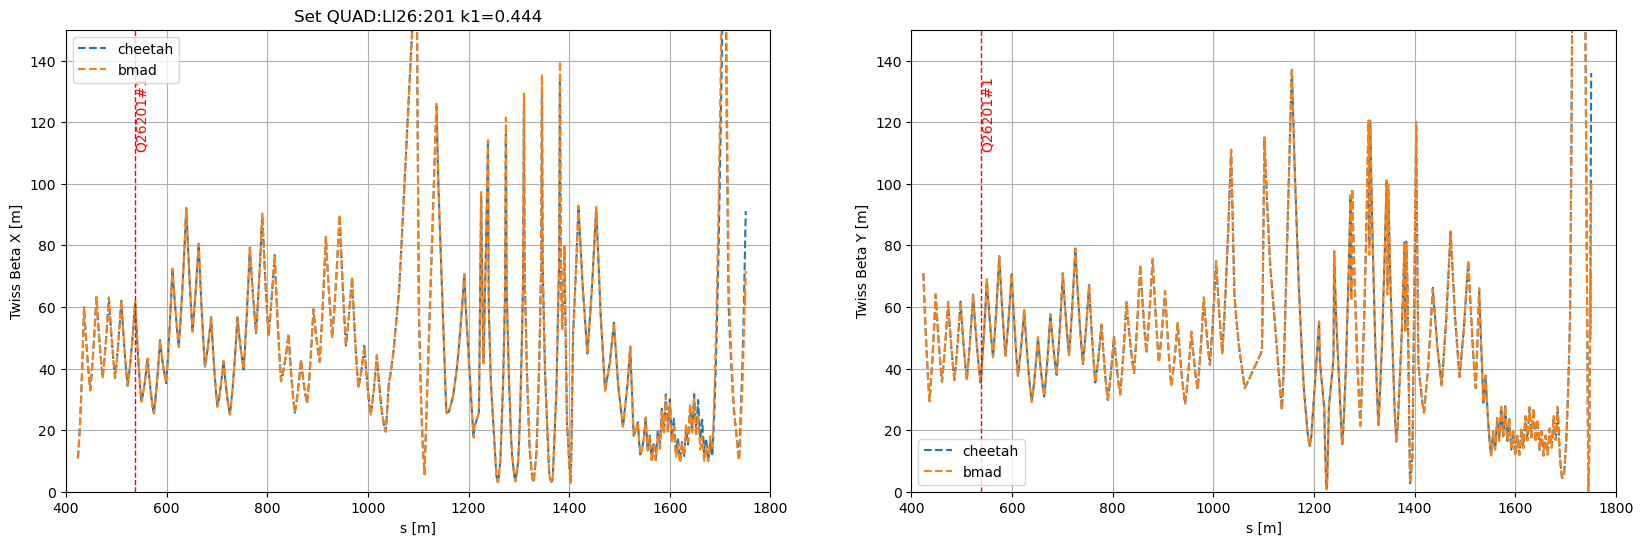

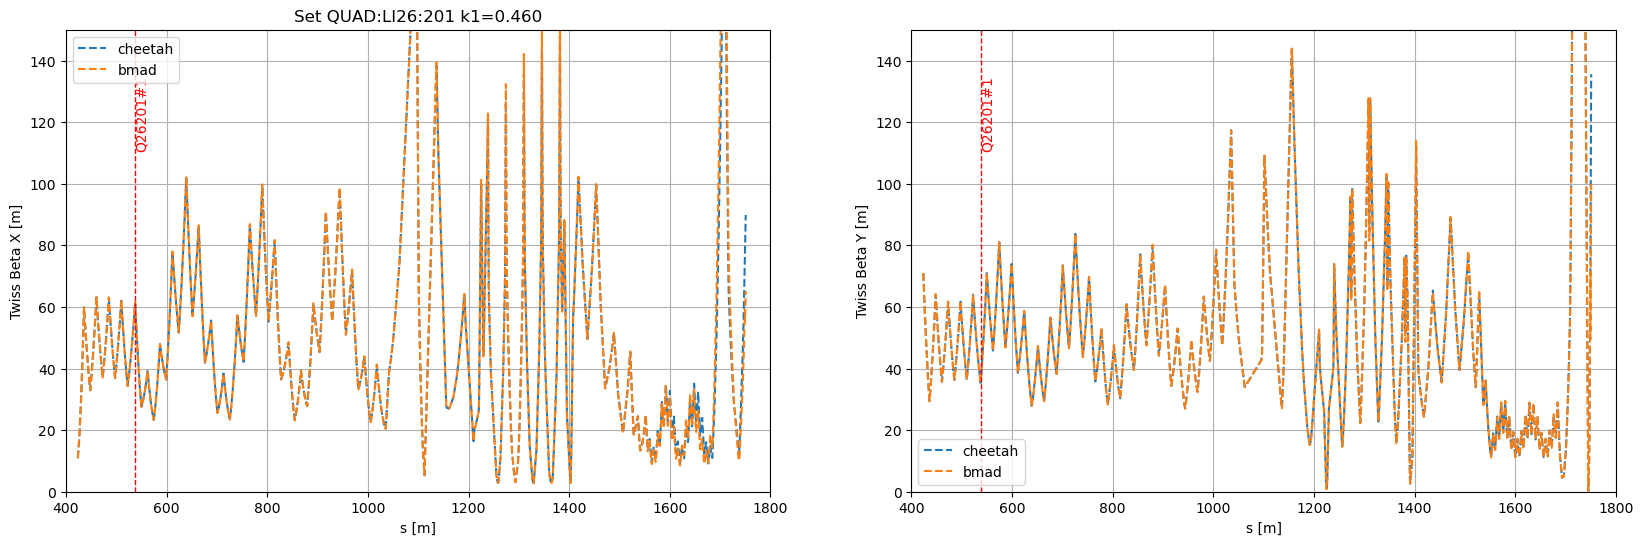

In [27]:
for scan_value, output in bmad_outputs.items():

    cheetah_data = cheetah_outputs[scan_value]
    cheetah_s = cheetah_data['s']
    cheetah_beta_x = cheetah_data['beta_x']
    cheetah_beta_y = cheetah_data['beta_y']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  
    ax1.set_title(f'Set QUAD:LI26:201 k1={scan_value:.3f}')
    ax1.plot(cheetah_s+bmad_output['ele.s'][bmad_start_index[0]], cheetah_beta_x, linestyle = '--', label=r'cheetah')
    ax1.plot(output['ele.s'], output['ele.a.beta'], linestyle = '--', label=r'bmad')
    ax1.set_xlabel('s [m]')
    ax1.set_ylabel('Twiss Beta X [m]')
    ax1.set_xlim(xlims)
    ax1.set_ylim([0,150])
    ax1.grid()
    ax1.legend()
    
    ax2.set_xlabel('s [m]')
    ax2.set_ylabel('Twiss Beta Y [m]')
    ax2.plot(cheetah_s+bmad_output['ele.s'][bmad_start_index[0]], cheetah_beta_y, linestyle = '--', label=r'cheetah')
    ax2.plot(output['ele.s'], output['ele.b.beta'], linestyle = '--', label=r'bmad')
    ax2.set_xlim(xlims)
    ax2.set_ylim([0,150])
    ax2.grid()
    ax2.legend()
    
    for element, location in locations:
        if location is not None:
            ax1.axvline(x=location, color='red', linestyle='--', linewidth=1)
            ax1.text(location, ax1.get_ylim()[1] * 0.9, element, rotation=90, verticalalignment='top', color='red')
            ax2.axvline(x=location, color='red', linestyle='--', linewidth=1)
            ax2.text(location, ax2.get_ylim()[1] * 0.9, element, rotation=90, verticalalignment='top', color='red')

In [28]:
tao.ele_twiss('BCX351', which='model')

{'mode_flip': False,
 'beta_a': 37.1886114917613,
 'alpha_a': -2.72255922291188,
 'gamma_a': 0.226207120535442,
 'phi_a': 7.15371898838335,
 'eta_a': 0.00124737761845175,
 'etap_a': 0.00712795132302706,
 'beta_b': 79.7412347496609,
 'alpha_b': -3.24471882793526,
 'gamma_b': 0.144570124961686,
 'phi_b': 4.84057509411614,
 'eta_b': 2.68085705790264e-15,
 'etap_b': 4.51169981327722e-16,
 'eta_x': 0.00124737761845175,
 'etap_x': 0.00712795132302706,
 'eta_y': 2.68085111051611e-15,
 'etap_y': 4.51169782801979e-16}

In [25]:
tao.cmd('sho ele end*')

['       380  ENDL2                                          396.019',
 '       439  ENDBC2                                         423.735',
 '      1163  ENDL3                                         1027.340',
 '      1192  ENDCLTH_0                                     1035.847',
 '      1203  ENDCLTH_1                                     1043.792',
 '      1222  ENDCLTH_2                                     1096.296',
 '      1242  ENDBSYH_1                                     1102.744',
 '      1329  ENDBSYH_2                                     1209.357',
 '      1777  ENDLTUH                                       1548.085',
 '      2624  ENDUNDH                                       1703.832',
 '      2690  ENDDMPH_1                                     1719.756',
 '      2741  ENDDMPH_2                                     1750.883',
 '      2742  END                                           1750.883',
 'Number of Matches: 13']

In [41]:
tao.cmd('sho lat -s 0:15')

['# Values shown are for the Downstream End of each Element:',
 '# Index  name     key                       s       l    beta   phi_a    eta   orbit    beta   phi_b    eta   orbit  Track',
 '#                                                           a   [2pi]      x  x [mm]       b   [2pi]      y  y [mm]  State',
 '      1  YAG03    Monitor               4.615   0.000   17.20   0.000   0.00   0.000   17.20   0.000   0.00   0.000  Alive',
 '      2  DL02A2   Drift                 4.727   0.113   18.30   0.001   0.00   0.000   18.30   0.001   0.00   0.000  Alive',
 '      3  DL02A3   Drift                 4.801   0.074   19.04   0.002   0.00   0.000   19.04   0.002   0.00   0.000  Alive',
 '      4  QA01     Quadrupole            4.909   0.108   22.51   0.002   0.00   0.000   17.95   0.003   0.00   0.000  Alive',
 '      5  DL02B1   Drift                 5.003   0.094   28.19   0.003   0.00   0.000   15.28   0.003   0.00   0.000  Alive',
 '      6  PH01     Instrument            5.003 

In [116]:
import torch

def calculate_emittance(beta, alpha, gamma):
    # Calculate emittance using the formula
    emittance = torch.sqrt(beta * gamma - alpha**2)
    return emittance

# Example values for beta, alpha, and gamma
beta = torch.tensor( 71.0120272732478)   # Example beta function value
alpha = torch.tensor( 2.2065488063062)  # Example alpha function value
gamma = torch.tensor( 0.0826459666054668)  # Example gamma function value

emittance = calculate_emittance(beta, alpha, gamma)

print(f"Emittance: {emittance}")


Emittance: 1.000000238418579


In [96]:
data = pd.read_pickle('05MAY2024_emittance_data.pd.pkl')
data

QUAD:LI26:201:BACT  WIRE:LI28:144:BETA_X  \
2024-05-23 15:54:46            8.093677             70.331541   
2024-05-23 16:00:35            8.903442             76.473047   
2024-05-23 16:09:37            9.712831            102.285453   
2024-05-23 16:33:18            8.985489             70.902007   
2024-05-23 16:41:47            8.875331             67.344228   
2024-05-23 16:47:23            9.617670             72.289944   
2024-05-23 16:51:23            8.121260             73.163530   
2024-05-23 16:56:10            8.701696             98.407518   
2024-05-23 17:08:17            8.093690             98.407518   
2024-05-23 17:10:12            8.093684             98.407518   

                     WIRE:LI28:144:ALPHA_X  WIRE:LI28:144:EMITN_X  \
2024-05-23 15:54:46              -1.683926               1.382935   
2024-05-23 16:00:35              -2.030483               1.378931   
2024-05-23 16:09:37              -2.917319               1.211793   
2024-05-23 16:33:18              -1.719866               1.439775   
2024-05-23 16:41:47              -1.418937               1.430357   
2024-05-23 16:47:23              -1.992158               1.569814   
2024-05-23 16:51:23              -1.636320               1.763365   
2024-05-23 16:56:10              -1.991008               1.791838   
2024-05-23 17:08:17              -1.991008               1.791838   
2024-05-23 17:10:12              -1.991008               1.791838   

                     WIRE:LI28:144:BETA_Y  WIRE:LI28:144:ALPHA_Y  \
2024-05-23 15:54:46            117.539288               0.031063   
2024-05-23 16:00:35             87.044296              -0.013410   
2024-05-23 16:09:37             89.219199              -0.061415   
2024-05-23 16:33:18             83.519476               0.616939   
2024-05-23 16:41:47             63.058188               0.347524   
2024-05-23 16:47:23             66.788331               0.887044   
2024-05-23 16:51:23            188.693109               1.694709   
2024-05-23 16:56:10            200.185652              -0.124525   
2024-05-23 17:08:17            200.185652              -0.124525   
2024-05-23 17:10:12            200.185652              -0.124525   

                     WIRE:LI28:144:EMITN_Y  OTRS:IN20:621:BETA_X  \
2024-05-23 15:54:46               0.752032              5.157998   
2024-05-23 16:00:35               0.908148              5.157998   
2024-05-23 16:09:37               0.886346              5.157998   
2024-05-23 16:33:18               0.924814              5.157998   
2024-05-23 16:41:47               1.356406              5.157998   
2024-05-23 16:47:23               1.436876              5.157998   
2024-05-23 16:51:23               0.642565              5.157998   
2024-05-23 16:56:10               0.365351              5.157998   
2024-05-23 17:08:17               0.365351              3.640401   
2024-05-23 17:10:12               0.365351              4.294708   

                     OTRS:IN20:621:ALPHA_X  OTRS:IN20:621:EMITN_X  \
2024-05-23 15:54:46              -1.819730               0.475706   
2024-05-23 16:00:35              -1.819730               0.475706   
2024-05-23 16:09:37              -1.819730               0.475706   
2024-05-23 16:33:18              -1.819730               0.475706   
2024-05-23 16:41:47              -1.819730               0.475706   
2024-05-23 16:47:23              -1.819730               0.475706   
2024-05-23 16:51:23              -1.819730               0.475706   
2024-05-23 16:56:10              -1.819730               0.475706   
2024-05-23 17:08:17              -1.289654               0.521060   
2024-05-23 17:10:12              -1.450185               0.473590   

                     OTRS:IN20:621:BETA_Y  OTRS:IN20:621:ALPHA_Y  \
2024-05-23 15:54:46              3.821486              -1.622207   
2024-05-23 16:00:35              3.821486              -1.622207   
2024-05-23 16:09:37              3.821486              -1.622207   
2024-05-23 16:3

In [29]:
condition = (390 < s + bmad_output['ele.s'][bmad_start_index]) & (s + bmad_output['ele.s'][bmad_start_index] < 430)
matching_indices = np.where(condition)[0]
for idx in matching_indices:
    print(f"beta_x of element {cheetah_output['ele_name'][idx-1]} at s {s[idx] + bmad_output['ele.s'][bmad_start_index]}: {cheetah_output['beta_x'][idx]}")



beta_x of element k24_6c at s tensor([392.9749], dtype=torch.float64): tensor([48.1802], dtype=torch.float64)
beta_x of element k24_6d at s tensor([396.0190], dtype=torch.float64): tensor([50.1988], dtype=torch.float64)
beta_x of element li24term at s tensor([396.0190], dtype=torch.float64): tensor([50.1988], dtype=torch.float64)
beta_x of element endl2 at s tensor([396.0190], dtype=torch.float64): tensor([50.1988], dtype=torch.float64)
beta_x of element begbc2 at s tensor([396.0190], dtype=torch.float64): tensor([50.1988], dtype=torch.float64)
beta_x of element dm20 at s tensor([396.0532], dtype=torch.float64): tensor([50.2239], dtype=torch.float64)
beta_x of element q24701a at s tensor([396.1600], dtype=torch.float64): tensor([50.7746], dtype=torch.float64)
beta_x of element d10cma at s tensor([396.2870], dtype=torch.float64): tensor([52.6660], dtype=torch.float64)
beta_x of element q24701b at s tensor([396.3938], dtype=torch.float64): tensor([54.1439], dtype=torch.float64)
beta_x of

/lscratch/zihanzhu/tmp/ipykernel_426706/649770433.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"beta_x of element {cheetah_output['ele_name'][idx-1]} at s {s[idx] + bmad_output['ele.s'][bmad_start_index]}: {cheetah_output['beta_x'][idx]}")


In [27]:
import io
floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)

In [34]:
a= floorplan[floorplan['ElementType']=='SBend']['ElementName'].tolist()